# **Notebook by:** Taimoor Hasan Khan ([github](https://github.com/thkodin/zkc-node-classification))

***Please collapse everything except the editor to view output cells properly.***

# Task
---

Classify nodes in a graph using different types of GNNs:
1. Graph Convolutional Network (GCN) 
2. Graph Sample and Aggregation (GraphSAGE)
3. Graph Attention Transformers / Networks (GAT)

We'll be using:
- **Graph Dataset:** Zachary's Karate Club Network (ZKC) PyG variant with 4 classes.
- **Language:** Python
- **Main Modules:** PyTorch Geometric, NetworkX, Sklearn for TSNE and PCA
- **Split Setting:** Transductive owing to small size of ZKC.

# Animation Links
---
The blocks to animate take a long time (up to 10 minutes for all blocks @ 500 epochs with TSNE) as it performs first either PCA/TSNE, and then saves/encodes the video locally, then re-ecnodes to HTML format for display in the output cell. Consider commenting the animation blocks and viewing the following links for the animation instead. The rest of the code should run reasonably fast.

### a) 4 Train - 30 Val
- [GCN](https://drive.google.com/file/d/1hlPucOJDIUk4tmjTyCQ_d7UjPWuKI6Zn/view?usp=sharing)
- [GSAGE](https://drive.google.com/file/d/13ns0hhZJcNHakxkwZt8rJ4ayPZXVi6I5/view?usp=sharing)
- [GAT](https://drive.google.com/file/d/1F_8CexTKr_Q9yz6i9OULCr0KyefJVmsD/view?usp=sharing)
- [Side-by-side](https://drive.google.com/file/d/1CpwjTWCR5TmIoq4h4IGP37jfAGYI7ilw/view?usp=sharing)

### b) 4 Train - 4 Val - 26 Test
- [GCN](https://drive.google.com/file/d/1hlPucOJDIUk4tmjTyCQ_d7UjPWuKI6Zn/view?usp=sharing)
- [GSAGE](https://drive.google.com/file/d/13ns0hhZJcNHakxkwZt8rJ4ayPZXVi6I5/view?usp=sharing)
- [GAT](https://drive.google.com/file/d/1F_8CexTKr_Q9yz6i9OULCr0KyefJVmsD/view?usp=sharing)
- [Side-by-side](https://drive.google.com/file/d/1QfAFhneuewTBaGk6hNXmM6hVWpAPj8fo/view?usp=sharing)

### ***Validation or Train Time Embeddings?***

Note that the animated embeddings are not the training embeddings (i.e., not embeddings part of the training loop for that epoch) but instead the validation embeddings. 

Once the training accuracy and loss are computed for an epoch and the model params have been updated with the `optimizer.step()`, we pass the entire graph through the updated model for another set of predictions (labels and embeddings) over all nodes, which we then mask the validation subset over to get the validation loss and accuracy. All of this is done in evaluation mode (`torch.eval`) with no grad, which disables BatchNorm, Dropout, etc. layers and gradient computation. Therefore, these embeddings (and consequently predicted labels and loss/accuracy) are calculated without the dropout used in training. 

This is both a technically reasonable and personal choice. The training embeddings are very noisy due to dropout (as they should be), making the animation extremely jumpy and hard to follow. Technically though, one may argue that since testing also disables dropout or batch norm, it makes sense to visualize the embedding history in the same setting. Regardless, it should be noted that removing dropout from the architecture removes the jumpiness in the training embeddings, and even with dropout it is fine to return the training embeddings &ndash; albeit not so pleasant to look at.

# Overview of Results
---
We present the best model accuracies (model with minimum training *and* validation loss/acc) over 1000 epochs on all three models @ LR = 0.001, OPT = Adam, Loss = Negative Log Likelihood (same as Cross Entropy, but expects log softmax scores in PyTorch implementation). To ensure fair comparison, we have used the same number of layers and parameters for all three, and all random seeds were set to 42. The only thing that will change in the architecture is the graph convolution block. We further present the visualizations for all models' performances to see how they compare. 

**In our experience, for ZKC, GCN and GAT perform best for most settings. GraphSAGE either underfits or performs relatively poorly on all the settings we tested.**

The results are mostly expected because of the small size and static nature of ZKC. The inductive frameworks of GraphSAGE and GAT are much more suited for larger, complex, and dynamic graphs where GCN becomes quite costly (requirement of entire graph). Additionally, GAT and GraphSAGE excel at capturing local structure whereas GCN captures the global structure better. 

However, we did not expect GAT to outperform GCN or even GraphSAGE by such a large margin in any setting because of the small size and relatively few edges in the dataset. Interestingly, it's the best-performing model with the best loss/acc history at just 4/34 nodes for training. **We believe GAT's performance can be attributed to the fact that Node 0&mdash;a major node of interest representing the club instructor&mdash;is set as a training node (by default in PyG). In the graph, this node has a rich local structure as it connects to a lot of other nodes.** We think this is why it outperforms both models in several cases. It may also be possible to further improve performance by providing the node corresponding to the club president, i.e., Node 33.

# Model Architecture
---
```
Conv = GCNConv, GraphSAGE, or GATConv 
Layer 1: Conv (num_nodes i.e., 34 to 24) -> Tanh -> Dropout 
Layer 2: Conv (24 to 12) -> Tanh -> Dropout
Layer 3: Conv (12 to 6) -> Tanh -> Dropout
Layer 4: DenseClassifier (6 to num_classes i.e., 4) -> LogSoftmax
```
Since we use $\text{LogSoftmax} = \ln(\text{Softmax})$, the returned class/label scores for the nodes are negative. This is because $\text{Softmax}(x) \to [0, 1]$ and $\ln(1) = 0$, while $\ln(0) = \infty$. In this representation, scores closer to 0 are better, with 0 being 100% confidence. To get the prediction scores back in a more intuitive form though, we raise the result of `LogSoftmax()` to the power of Euler's number $e$ (base of $\ln = \log_e$). Hence, when we print the confidence scores, we use `np.exp()` to do so.

The dataset splits we have used are:
- **Train:** 4 nodes
- **Val  :** 4 nodes
- **Test :** 26 nodes

To use the whole graph apart from training nodes for validation, set the `val_mask` argument in the `train_model()` function to `val_mask + test_mask`. This validates on the entire graph apart from train nodes, but at the same time, does not allow truly testing the model. A val_mask of 4 nodes makes the classification a lot tougher for the network at test time, which really tests its metal.

The final embeddings by the model are 34x6 and the classifier output is 34x4 so the embeddings are 6D vectors against each node and the prediction vectors are 4D (scores against each of the 4 classes). To visualize these embeddings, we have utilized PCA (with the option to switch to TSNE but that takes longer) to reduce the embeddings to 2D. If the embeddings are already 2D, PCA/TSNE will return the original embeddings as a list of embeddings converted to numpy (if needed), but will not perform dimension reduction. This lets you swap the model's architecture without worrying about removing the PCA/TSNE blocks in visualizations.

> **Note that using three layers of graph-based operations is probably not the best idea for a small dataset like ZKC. This is further evidenced by the graphs that seem to overfit quite quickly (reducing LR makes for very long animations, but you can comment the block and check that it helps a bit as well). It may be possible to improve performance by truncating to two or one layer.**

# Additional Notes on GCN, GraphSAGE, and GAT
---
There are a few key differences in the models. The first is how they aggregate information from the graph. 
1. GCNConv convolves aggregates the node features alongside its neighbors, but it utilizes the normalized adjacency matrix to weigh them. This means it uses the **entire graph's features**. The **aggregation function** is a simple linear combination of the node & neighbor featrues, alongside the weighted adjacenecy matrix.
2. GraphSAGE (Sample and AGgrEgate) limits to just a **fixed-size neighborhood** and additionally samples them (does not use them all). The architecture is flexible and can take several **aggregation functions** including mean, pool, LSTM, etc.
3. GAT is like SAGE and limits to a certain **fixed size neighborhood**, but additionally uses attention heads to capture relative importance of the neighbors. The **aggregation function** is based on the learned coefficients of the attention mechanism alongside the hidden weights.

GCN is favored for transductive learning frameworks, whereas GraphSAGE and GAT are preferred for inductive learning frameworks. However&mdash;with the exception of GCN&mdash;they can practically be used in either setting.

In **transductive settings**, we provide the model with the full graph structure, and only splits the labels. So, during training, the model has access to all nodes and all edges, but it does not know the label of any node apart from the training and validation set. In this case, the splits are not completely indepdenent and are related by their structure. 

On the other hand, the **inductive learning framework** cuts off the edges between splits, forcing independence at the cost of structural relationships that may exist between them in the original graph. So for a single graph network, an inductive setting would split the graph into three subgraphs, and the respective losses and accuracies are evaluated in isolation within each set/graph (train acc can only be observed on train nodes, test acc only on test nodes, etc.)

We also note that our setup is not the *best* way to compare on the basis of transductivity/inductivity, since the graph is **static**. The real advantage of inductive frameworks is in generalizing to new and unseen nodes, aka **dynamically growing graphs**. In that case, a GCN would need to be retrained from scratch for every new iteration of the graph, whereas GAT and GraphSAGE would work just fine owing to their inductive learning nature.

\begin{array}{llll}
\hline
\textbf{Method} & \textbf{Approach} & \textbf{Aggregation Method} & \textbf{Flexibility} \\
\hline
\text{GCN} & 
\text{numerical} & 
\begin{aligned}
&\text{linear combination} \\ &\text{weighted by normalized adjacency} 
\end{aligned} &
\begin{aligned}
&\text{limited} \\ &\text{retrain if graph changes} 
\end{aligned}
\\
\hline
\text{GSAGE} & \text{inductive} & 
\begin{aligned}
&\text{sampled neighbors} \\ &\text{various aggregation functions} 
\end{aligned} & 
\begin{aligned}
&\text{adaptive} \\ &\text{generalizes to unseen nodes}
\end{aligned}
\\
\hline
\text{GAT} & \text{attention} & 
\begin{aligned}
&\text{neighbor features} \\ &\text{learned attention coefficients}
\end{aligned} & 
\begin{aligned}
&\text{highly adaptive} \\ &\text{generalizes to unseen nodes}
\end{aligned} 
\\
\hline
\end{array}

***
# Preliminary
Note that terms "labels" and "classes" are used interchangeably in this notebook. Generally, however, node labels refers to the node numbers, e.g., for Node 1, Node 2, ..., Node 34 in ZKC, the array [0, 1, 2, ..., 33] is usually the label array. That is not the case here. We call these the node numbers instead.

The label array in our usage is the array where the indices represent the node numbers, and the actual values represent the class for the nodes. This works for ZKC; might not for other datasets.

In [1]:
# CORE: -q = --quiet, quiet installation.
!pip -q install torch torch-geometric
# EXTRA: Times block runs automatically.
!pip -q install ipython-autotime
%load_ext autotime

time: 453 µs (started: 2023-05-07 03:28:31 +00:00)


- `tqdm` for progress bars. 
- `netowrkx` for graph visualizations. 
- `matplotlib` for embedding visualizations and animation of training epochs. 
- `sklearn` for reducing dimensions of network embeddings which may offer better results than the 2D embeds from HW.
- `torch_geometric` and `torch` for graph-based neural networks. 
- `IPython.display.HTML()` for animation gif in output cell.

In [2]:
import sys
from tqdm import tqdm
import numpy as np
from copy import deepcopy

import torch
from torch.nn import Linear, Dropout, ReLU, Tanh, Sigmoid, LogSoftmax, NLLLoss
from torch.optim import Adam
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.utils import to_networkx, to_undirected
import networkx as nx

# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, to_rgba
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation, FFMpegWriter
plt.rcParams.update({'font.size': 14})

from IPython.display import HTML, Video
from base64 import b64encode

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(42)

time: 3.32 s (started: 2023-05-07 03:28:31 +00:00)


# Step 1: Define the Graph Networks

In [3]:
# @title Graph Networks
# These classes will inherit the methods and attributes of torch.nn.Module base class.
class GCN(torch.nn.Module):
    def __init__(self, dataset):
        """Creates a graph convolutional network (GCN) based on the torch.nn.Module base class. 
        # ARCHITECTURE:
            Layer 1: GCNConv (num_features to 24) -> Tanh -> Dropout 
            Layer 2: GCNConv (24 to 12) -> Tanh -> Dropout
            Layer 3: GCNConv (12 to 6) -> Tanh -> Dropout
            Layer 4: DenseClassifier (6 to num_classes) -> LogSoftmax
        # PARAMETERS:
            dataset: A `torch_geometric.data.Dataset` object.
        """

        # Initialize the base class (torch.nn.Module) constructor for GCN class.
        super().__init__()
        torch.manual_seed(42)

        # Define the network's layers. In this case, we add two GCNConv blocks.
        # torch_geometric.nn.GCNConv(input_size, num_neurons). Output size equals num_neurons.

        # Layer 1
        # ============================
        self.conv1 = GCNConv(dataset.num_features, 24)
        self.act1 = Tanh()
        self.dropout1 = Dropout(p=0.15)

        # Layer 2
        # ============================
        self.conv2 = GCNConv(24, 12)
        self.act2 = Tanh()
        self.dropout2 = Dropout(p=0.15)

        # # Layer 3 - Final Embeddings
        # # ============================
        self.conv3 = GCNConv(12, 6)
        self.act3 = Tanh()
        self.dropout3 = Dropout(p=0.15)

        # Layer 4
        # ============================
        self.classifier = Linear(6, dataset.num_classes)
        self.act4 = LogSoftmax(dim=1)  

        # NOTE on Layer 4: Our feature map has the shape (num_nodes, num_classes). We need 
        # softmax along dim_node_features for each row (node) so dim needs to be 1. This applies 
        # softmax along columns (picks a row/node, then softmaxes over its columns/feature_vector).

    def forward(self, data):
        """Forward pass through the network.
        # PARAMETERS:
            data: A `torch_geometric.data.Data` object.
        # RETURNS:
            preds: The normalized (via softmax) classification vector.
        """
        input, edge_index = data.x, data.edge_index
        h = self.conv1(input, edge_index)
        h = self.act1(h)
        h = self.dropout1(h)
        h = self.conv2(h, edge_index)
        h = self.act2(h)
        h = self.dropout2(h)
        h = self.conv3(h, edge_index)
        embeddings = self.act3(h)
        h = self.dropout3(embeddings)

        # In DL, logits are the final layer's output without activation. Not to be confused with
        # the mathematical function.
        logits = self.classifier(h)
        preds = self.act4(logits)

        return preds, embeddings

# I will not be commenting for the next two classes. They follow the same process, just the
# conv operation will change from GCNConv to SAGEConv and GATConv.

class GraphSAGE(torch.nn.Module):
    def __init__(self, dataset):
        """Creates a graph convolutional network (GCN) based on the torch.nn.Module base class. 
        # ARCHITECTURE:
            Layer 1: SAGEConv (num_features to 24) -> Tanh -> Dropout 
            Layer 2: SAGEConv (24 to 12) -> Tanh -> Dropout
            Layer 3: SAGEConv (12 to 6) -> Tanh -> Dropout
            Layer 3: DenseClassifier (6 to num_classes) -> LogSoftmax
        # PARAMETERS:
            dataset: A `torch_geometric.data.Dataset` object.
        """
        super().__init__()
        torch.manual_seed(42)

        self.conv1 = SAGEConv(dataset.num_features, 24)
        self.act1 = Tanh()
        self.dropout1 = Dropout(p=0.15)
        self.conv2 = SAGEConv(24, 12)
        self.act2 = Tanh()
        self.dropout2 = Dropout(p=0.15)
        self.conv3 = SAGEConv(12, 6)
        self.act3 = Tanh()
        self.dropout3 = Dropout(p=0.15)
        self.classifier = Linear(6, dataset.num_classes)
        self.act4 = LogSoftmax(dim=1)  

    def forward(self, data):
        """Forward pass through the network.
        # PARAMETERS:
            data: A `torch_geometric.data.Data` object.
        # RETURNS:
            preds: The normalized (via softmax) classification vector.
        """
        input, edge_index = data.x, data.edge_index
        h = self.conv1(input, edge_index)
        h = self.act1(h)
        h = self.dropout1(h)
        h = self.conv2(h, edge_index)
        h = self.act2(h)
        h = self.dropout2(h)
        h = self.conv3(h, edge_index)
        embeddings = self.act3(h)
        h = self.dropout3(embeddings)
        logits = self.classifier(h)
        preds = self.act4(logits)

        return preds, embeddings

class GAT(torch.nn.Module):
    def __init__(self, dataset):
        """Creates a graph attention transformer (GAT) based on the torch.nn.Module base class. 
        # ARCHITECTURE:
            Layer 1: GATConv (num_features to 24) -> Tanh -> Dropout
            Layer 2: GATConv (24 to 12) -> Tanh -> Dropout
            Layer 3: GATConv (12 to 6) -> Tanh -> Dropout
            Layer 4: DenseClassifier (6 to num_classes) -> LogSoftmax
        # PARAMETERS:
            dataset: A `torch_geometric.data.Dataset` object.
        """
        super().__init__()
        torch.manual_seed(42)

        # By default, no. of attention heads equals 1. Can change with `heads` keyword argument.
        self.conv1 = GATConv(dataset.num_features, 24)
        self.act1 = Tanh()
        self.dropout1 = Dropout(p=0.15)
        self.conv2 = GATConv(24, 12, heads=1)
        self.act2 = Tanh()
        self.dropout2 = Dropout(p=0.15)
        self.conv3 = GATConv(12, 6, heads=1)
        self.act3 = Tanh()
        self.dropout3 = Dropout(p=0.15)
        self.classifier = Linear(6, dataset.num_classes)
        self.act4 = LogSoftmax(dim=1)  

    def forward(self, data):
        """
        Forward pass through the network.
        # PARAMETERS:
            data: A `torch_geometric.data.Data` object.
        # RETURNS:
            preds: The normalized (via softmax) classification vector.
        """
        input, edge_index = data.x, data.edge_index
        h = self.conv1(input, edge_index)
        h = self.act1(h)
        h = self.dropout1(h)
        h = self.conv2(h, edge_index)
        h = self.act2(h)
        h = self.dropout2(h)
        h = self.conv3(h, edge_index)
        embeddings = self.act3(h)
        h = self.dropout3(embeddings)
        logits = self.classifier(h)
        preds = self.act4(logits)

        return preds, embeddings

time: 5.06 ms (started: 2023-05-07 03:28:34 +00:00)


# Step 2 &ndash; Functions
Main bulk of code. Train, Test, TSNE/PCA, visualizations, animation etc. It's kind of long, so the viewer can just skip to the next parts if not editing code.

In [4]:
# @title Bunch of Functions - Skip if Just Viewing
animation_progress_callback = lambda i, n: print(f"\rSaving frame: {i+1}/{n}", end="")
gen_hex_colors_per_class  = lambda colormap, num_classes: [to_hex(colormap(i)) for i in np.linspace(0, 1, num_classes)]
# Equivalent: 
# gen_rgba_colors_per_class = lambda colormap, num_classes: [colormap(i / (num_classes - 1)) for i in range(num_classes)]

def get_tsne_embeddings(
    embeddings, 
    random_state=42, 
    perplexity=10, 
    early_exaggeration=16.0, 
    use_prev_embed_to_init_new=False
):
    """Generates 2D TSNE embeddings via sklearn.manifold.TSNE() for a given list of high-dimensional data.
    ### PARAMETERS
        `embeddings` (list of ndarray or list of torch.tensor): List of high-dimensional embeddings to generate 
    TSNE of. Each element of the list may be n-dimensional of the shape (num_nodes, embedding_dimension), 
    i.e., each row is a separate instance of the same quantity represented with another embedding of equal 
    dims. The list format helps facilitate creating embeddings for comparison.
        `random_state` (int, optional): TSNE argument. Sets the model's random state for learning the 2D embeddings.
        `perplexity` (int, optional): TSNE argument. Defines how much importance local structures are given in 
    generating the embeddings. If low, captures global structure better. If high, captures local structure better.
    CANNOT be larger than the number of samples (nodes) in the graph.
        `early_exaggeration` (float, optional): TSNE argument. Defines how far apart the learnt 2D embeddings are,
    aka how exaggerated the embedding distances appear.
        `use_prev_embed_to_init_new` (bool, optional): If set, only initializes with PCA when calculating 
    the first TSNE embedding. All the following embeddings recursively utilize the latest TSNE embedding as
    the initial guess. Useful when animating (creates a more cohesive result).
    ### RETURNS
        `tsne_embeddings` (list of ndarray): List of 2D TSNE embeddings of the shape (num_nodes, 2).
    """
    # INPUT CHECKING
    # ==============
    errors = []
    warnings = []
    has_errors = False
    has_warnings = False

    # Force convert to list of tensors if not a list (even if just a single epoch's embeddings).
    if not isinstance(embeddings, list):
        has_warnings = True
        msg = "- Provided embeddings were not a list of embeddings. Converting to list..."
        try:
            embeddings = [embeddings]
            msg += "done."
        except:
            has_errors = True
            msg += "failed."
            errors.append("- Could not convert given embeddings to list of embeddings.")
        warnings.append(msg)

    # Convert to numpy if tensor.
    encountered_tensor = False
    for i, embedding in enumerate(embeddings):
        
        if torch.is_tensor(embedding):
            if not encountered_tensor:
                has_warnings = True
                msg = "- Encountered tensor embeddings. Converting to numpy ndarray..."
            try:
                embeddings[i] = embedding.detach().cpu().numpy()
                if not encountered_tensor:
                    msg += "done."
                    encountered_tensor = True
            except:
                if not encountered_tensor:
                    has_errors = True
                    msg += "failed."
                    errors.append("- Could not convert tensor embedding to numpy.")
                    encountered_tensor = True
            warnings.append(msg)
        
        elif not isinstance(embedding, np.ndarray):
            has_errors = True
            errors.append("- Given embedding was neither a torch.tensor nor a numpy.ndarray.")

    if has_warnings:
        print("[WARNINGS]\n\t" + "\n\t".join(warn for warn in warnings))
    if has_errors:
        error_msg = "Failed to visualize embeddings.\n\t" + "\n\t".join(err for err in errors)
        sys.exit(error_msg)

    if embeddings[i].shape[1] == 2:
        print("[INFO] Embeddings already 2D. Returning them unchanged as list of ndarray.")
        return embeddings

    # TSNE DIM REDUCTION
    # ==================
    tsne_embeddings = []

    if use_prev_embed_to_init_new:
        # Get first TSNE embedding with PCA initialization (default).
        tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, 
                    early_exaggeration=early_exaggeration)
        tsne_embedding = tsne.fit_transform(embeddings[0])
        tsne_embeddings.append(tsne_embedding)

        # Implement TSNE for all following embeddings by initializing from the latest TSNE embedding.
        # This should make the animation more coherent, rather than randomly initializing with
        # PCA every time.
        for embedding in tqdm(embeddings[1:], desc="Reducing embeddings to 2D", ascii=True):
            tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, 
                        early_exaggeration=early_exaggeration, init=tsne_embeddings[-1],
                        learning_rate='auto')  
            tsne_embedding = tsne.fit_transform(embedding)
            tsne_embeddings.append(tsne_embedding)

    else:
        for embedding in tqdm(embeddings, desc="Reducing embeddings to 2D", ascii=True):
            tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, 
                        early_exaggeration=early_exaggeration)  
            tsne_embedding = tsne.fit_transform(embedding)
            tsne_embeddings.append(tsne_embedding)

    return tsne_embeddings


def get_pca_embeddings(
    embeddings, 
    random_state=42, 
    whiten=True
):
    """Generates 2D PCA embeddings via sklearn.decomposition.PCA() for a given list of high-dimensional data.
    Inherently utilizes the full SVD solver to generate the 2D embeddings. Much faster than TSNE and better
    maintains global structure, but it is linear and will not model complex local relationships well. 
    ### PARAMETERS
        `embeddings` (list of ndarray or list of torch.tensor): List of high-dimensional embeddings to generate 
    PCA of. Each element of the list may be n-dimensional of the shape (num_samples, embedding_dimension), 
    i.e., each row is a separate instance of the same quantity represented with another embedding of equal 
    dims. The list format helps facilitate creating embeddings for comparison.
        `random_state` (int, optional): The random seed to use for the PCA operation.
        `whiten` (bool, optional): The whiten argument in sklearn.decomposition.PCA(). If set, normalizes the 
    values using the singular values and standard deviation.
    ### RETURNS
        `pca_embeddings` (list of ndarray or list of torch.tensor): List of 2D PCA embeddings of the shape 
    (num_samples, 2).
    """
    # INPUT CHECKING
    # ==============
    errors = []
    warnings = []
    has_errors = False
    has_warnings = False

    # Force convert to list of tensors if not a list (even if just a single epoch's embeddings).
    if not isinstance(embeddings, list):
        has_warnings = True
        msg = "- Provided embeddings were not a list of embeddings. Converting to list..."
        try:
            embeddings = [embeddings]
            msg += "done."
            warnings.append(msg)
        except:
            has_errors = True
            msg += "failed."
            warnings.append(msg)
            errors.append("- Could not convert given embeddings to list of embeddings.")

    # Convert to numpy if tensor.
    encountered_tensor = False
    for i, embedding in enumerate(embeddings):
        
        if torch.is_tensor(embedding):
            if not encountered_tensor:
                has_warnings = True
                msg = "- Encountered tensor embeddings. Converting to numpy ndarray..."
            try:
                embeddings[i] = embedding.detach().cpu().numpy()
                if not encountered_tensor:
                    msg += "done."
                    warnings.append(msg)
                    encountered_tensor = True
            except:
                if not encountered_tensor:
                    has_errors = True
                    msg += "failed."
                    warnings.append(msg)
                    errors.append("- Could not convert tensor embedding to numpy.")
                    encountered_tensor = True
        
        elif not isinstance(embedding, np.ndarray):
            has_errors = True
            errors.append("- Given embedding was neither a torch.tensor nor a numpy.ndarray.")

    if has_warnings:
        print("[WARNINGS]\n\t" + "\n\t".join(warn for warn in warnings))
    if has_errors:
        error_msg = "Failed to visualize embeddings.\n\t" + "\n\t".join(err for err in errors)
        sys.exit(error_msg)

    if embeddings[i].shape[1] == 2:
        print("[INFO] Embeddings already 2D. Returning them unchanged as list of ndarray.")
        return embeddings

    # PCA DIM REDUCTION
    # =================

    pca_embeddings = []

    for embedding in tqdm(embeddings, desc="Reducing embeddings to 2D", ascii=True):
        pca = PCA(n_components=2, svd_solver="full", random_state=random_state)  
        pca_embedding = pca.fit_transform(embedding)
        pca_embeddings.append(pca_embedding)

    return pca_embeddings


def train_model(
    model,
    data, 
    train_mask,
    val_mask,
    criterion=None, 
    optimizer=None,  
    num_epochs=250, 
    modelname="model",
    save_history=False,
    return_best_only=False
):
    """
    Train the given model using the given graph data and train and validation masks.
    ### PARAMETERS
        `model` (torch.nn.Module): The PyTorch model to train.
        `data` (torch_geometric.data.Data): The graph dataset as loaded into PyTorch. 
        `train_mask` (bool ndarray): Mask for the training subset of nodes.
        `val_mask` (bool ndarray): Mask for the validation subset of nodes.
        `criterion` (torch.nn.Crietrion, optional): One of the torch.nn loss criterions. If none, uses Negative Log 
    Likelihood loss.  
        `optimizer` (torch.optim.Optimizer, optional): One of the torch.optim optimizers. If none, uses the ADAM 
    optimizer.
        `num_epochs` (int, optional): The number of epochs to train the model for.
        `modelname` (str, optional): The name to save the model to disk with.
        `save_history` (bool, optional): If set, returns a complete history of the training in dict of dict format.
    Saves embeddings, losses, and accuracies for each epoch.
        `return_best_only` (bool, optional): If set, returns and saves only the best model. The best model has the 
    lowest values for both training and validation losses and accuracies.
    ### RETURNS
        `model` (torch.nn.Module): The trained PyTorch model.
        `params` (dict of dicts): The outer key is a single epoch number (best or latest model), and its value is another
    dictionary with keys 'embeddings', 'labels', and 'metrics'. Embeddings is a 2D array of shape (num_nodes, embed_dims)
    representing the node embeddings, labels is the predicted label vector of size (num_nodes), and metrics is a dict
    with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'.
        `history` (dict of dicts): Full training history of the model (all epochs) in the same dict (key=epoch) of dicts 
    (keys=embeds, labels, metrics) form as `params`.
    """
    # Handle input arguments.
    metric_keys = ["train_loss", "val_loss", "train_acc", "val_acc"]
    if criterion is None:
        criterion = NLLLoss()
    if optimizer is None:
        optimizer = Adam(model.parameters(), lr=0.01)
    if save_history:              
        history = {
            epoch: {
                "embeddings": None,
                "labels": None,
                "metrics": {metric: None for metric in metric_keys}
            }
            for epoch in range(num_epochs)
        }

    # Init best metric trackers.
    best_model = None
    best_epoch = None
    best_embeddings = None
    best_labels = None
    best_train_loss = float("Inf")
    best_val_loss = float("Inf")
    best_train_acc = 0.
    best_val_acc = 0.

    # Separate the true labels for each split.
    true_labels = data.y
    train_true_labels = true_labels[train_mask]
    val_true_labels = true_labels[val_mask]

    for epoch in range(num_epochs):
        # ========
        # TRAINING
        # ========
        # Standard PyTorch training step. Set to train, zero gradients (since torch accumulates them
        # expecting batches), forward pass the data through the model, calculate loss value, backprop
        # through the model to calculate gradients, and make an optimizer step to update all params 
        # according to the gradients.
        model.train()
        optimizer.zero_grad()
        preds, pred_embeddings = model(data)
        train_loss = criterion(preds[train_mask], train_true_labels)  # loss only on subset of train nodes
        train_loss.backward()
        optimizer.step()

        # Find the maximum scoring indices (predicted labels) in the prediction matrix (nodes x num_labels).
        pred_labels = torch.argmax(preds, axis=1)

        # Calculate training accuracy on the subset of training nodes ONLY, based on which we also computed
        # our loss. If you have dropout, this will jump all over the place owing to the noise introduced.
        train_pred_labels = pred_labels[train_mask]
        train_acc = torch.mean(torch.where(train_pred_labels == train_true_labels, 1., 0.))

        # ==========
        # VALIDATION
        # ==========
        # Now that we are done with the training step and metric calculation, we use the updated model to
        # perform another set of predictions on the graph for validation, but this time in evaluation mode 
        # (disabling dropout and batch norm, if any). We don't want the validation to incorporate dropout
        # etc. since, at test time, we disable these layers anyway. So, the validation loss should be much
        # smoother than the training with dropout.
        model.eval()
        with torch.no_grad():
            # These embeddings will be different than train-time embeddings, since we updated the model and
            # there are no dropouts etc.
            preds, pred_embeddings = model(data)
            val_loss = criterion(preds[val_mask], val_true_labels)  # loss only on the subset of val nodes
        
        # Find the predicted labels on the subset of validation nodes ONLY, based on which we computed the
        # validation loss.
        pred_labels = torch.argmax(preds, axis=1)
        
        # Calculate validation accuracy on the subset of validation nodes ONLY, based on which we also 
        # computed our validation loss.
        val_pred_labels = pred_labels[val_mask]
        val_acc = torch.mean(torch.where(val_pred_labels == val_true_labels, 1., 0.))

        # ==========================
        # METRIC AND HISTORY UPDATES 
        # ==========================
        # Note: Save validation or train time embeddings & labels? Up to you. If dropout, validation embeddings 
        # are less noisy and make for smoother animations. Training embeddings will jump around everywhere.

        # Update previous bests if current epoch improved the loss while maintaining or improving both the 
        # train and validation accuracies.  
        if train_loss <= best_train_loss and val_loss <= best_val_loss and val_acc >= best_val_acc and train_acc >= best_train_acc:
            # Deepcopy the current model. It is necessary to deepcopy as PyTorch models are mutable, and we are 
            # currently training so it's changing weights and other params over time. 
            best_model = deepcopy(model)
            best_epoch = epoch
            best_embeddings = pred_embeddings.detach().cpu().numpy()
            best_labels = pred_labels.detach().cpu().numpy()
            best_train_loss = train_loss.item()
            best_val_loss = val_loss.item()
            best_train_acc = train_acc.item()
            best_val_acc = val_acc.item()

        # Add current metrics, embeddings, and labels to history.
        if save_history:
            history[epoch]["embeddings"] = pred_embeddings.detach().cpu().numpy()
            history[epoch]["labels"] = pred_labels.detach().cpu().numpy()
            history[epoch]["metrics"]["train_loss"] = train_loss.item()
            history[epoch]["metrics"]["val_loss"] = val_loss.item()
            history[epoch]["metrics"]["train_acc"] = train_acc.item()
            history[epoch]["metrics"]["val_acc"] = val_acc.item()

    # Fancy-schmancy (not really) printouts.
    print("========================================")
    print("              [BEST MODEL]              ") 
    print("========================================")
    print("@ Epoch:", best_epoch)
    print("Train Acc = {:.2f}%\nVal Acc: {:.2f}%\nTrain Loss: {:.2f}\nVal Loss: {:.2f}".format(
        best_train_acc * 100, best_val_acc * 100, best_train_loss, best_val_loss))
    print("========================================")
    print("             [LATEST MODEL]             ") 
    print("========================================")
    print("@ Epoch:", num_epochs - 1)
    print("Train Acc = {:.2f}%\nVal Acc: {:.2f}%\nTrain Loss: {:.2f}\nVal Loss: {:.2f}".format(
        train_acc * 100, val_acc * 100, train_loss, val_loss))
    print("========================================")

    if return_best_only:
        # Return and save the best model iteration.
        model = best_model
        metrics = [best_train_loss, best_val_loss, best_train_acc, best_val_acc]
        params = {
            best_epoch: {
                "embeddings": best_embeddings,
                "labels": best_labels,
                "metrics": dict(zip(metric_keys, metrics))
            }
        }
        torch.save(model.state_dict(), modelname + ".pt")
        print("[INFO] Saved and returned best model.")

    else:
        # Return and save the latest model iteration.
        epoch = num_epochs - 1
        metrics = [train_loss.item(), val_loss.item(), train_acc.item(), val_acc.item()]
        params = {
            epoch: {
                "embeddings": pred_embeddings.detach().cpu().numpy(),
                "labels": pred_labels.detach().cpu().numpy(),
                "metrics": dict(zip(metric_keys, metrics))
            }
        }
        torch.save(model.state_dict(), modelname + ".pt")
        print("[INFO] Saved and returned latest model.")

    return model, params, history
        

def evaluate_model(model, data, train_mask, val_mask, test_mask):
    """Fully evaluates the given PyTorch model for the task of node classification. Requires the training, testing, and
    validation masks used for training the graph. If the training used the entire graph apart from training for validation,
    `val_mask` and `test_mask` arguments should be the same. 
    ### PARAMETERS
        `model` (torch.nn.Module): The PyTorch model.
        `data` (torch_geometric.data.Data): The data object as loaded by PyTorch.
        `train_mask` (bool ndarray): Boolean mask indicating the training node set.
        `val_mask` (bool ndarray): Boolean mask indicating the validation node set.
        `test_mask` (bool ndarray): Boolean mask indicating the testing node set.
    ### RETURNS
        `predictions` (dict): A dictionary containing predicted embeddings, labels, confidences, the raw post-activation
    prediction scores from the final layer of the model, and the accuracy metrics. Labels & confidences are 1D vectors of
    size (num_nodes), whereas the raw prediction scores are 2D @ (num_nodes, num_labels). The accuracy metrics are a
    dict with keys 'all_acc', 'true_acc', 'val_acc', and 'test_acc'.
    """
    true_labels = data.y
    train_true_labels = true_labels[train_mask]
    val_true_labels = true_labels[val_mask]
    test_true_labels = true_labels[test_mask]

    model.eval()
    with torch.no_grad():
        # FIRST, we evaluate over all data.
        # 1. Forward pass to get classifier output and previous layer's embeddings.
        preds, pred_embeddings = model(data)
        
        # 2. From the classifier output of shape 34x4, get the maximum classification score 
        # against each node. Also get the corresponding index to this score - it's the node's
        # predicted label. Both the score and label vectors are 34x1.
        pred_max_scores, pred_labels = preds.max(dim=1)
        
        # 3. Get the number of correct predictions by element-wise comparing the true data labels
        # with the predicted node labels and taking the mean (sum the comparison results, then divide 
        # by number of nodes).
        all_acc = torch.mean(torch.where(pred_labels == true_labels, 1., 0.))
        # num_correct_preds = pred_labels.eq(data.y).sum().item()
        # all_acc = num_correct_preds / len(data.x) 

        # SECOND, Splitwise data evaluation. Procedure is the same, but this time we use split masks.
        # preds[train_mask] and preds[val_mask] are 4x4, and preds[test_mask] is 26x4.
        train_pred_labels = pred_labels[train_mask]
        val_pred_labels = pred_labels[val_mask]
        test_pred_labels = pred_labels[test_mask]
        
        train_acc = torch.mean(torch.where(train_pred_labels == train_true_labels, 1., 0.))
        val_acc = torch.mean(torch.where(val_pred_labels == val_true_labels, 1., 0.))
        test_acc = torch.mean(torch.where(test_pred_labels == test_true_labels, 1., 0.))

    print("========================================")
    print("          [EVALUATION RESULTS]          ")
    print("========================================")
    if np.array_equal(val_mask, test_mask):
        # Print only training and test accuracies if validation mask is the same as testing mask.
        accuracy_types = ["all_acc", "train_acc", "test_acc"]
        accuracies = [all_acc, train_acc, test_acc] 
        print("Overall Acc = {:.2f}%\nTrain Acc: {:.2f}%\nTest Acc: {:.2f}%".format(
            all_acc * 100, train_acc * 100, test_acc * 100))
    else:
        # Print all three split accuracies.
        accuracy_types = ["all_acc", "train_acc", "val_acc", "test_acc"]
        accuracies = [all_acc, train_acc, val_acc, test_acc] 
        print("Overall Acc = {:.2f}%\nTrain Acc: {:.2f}%\nVal Acc: {:.2f}%\nTest Acc: {:.2f}%".format(
            all_acc * 100, train_acc * 100, val_acc * 100, test_acc * 100))
    print("========================================")

    predictions = {
        "embeddings": pred_embeddings.detach().cpu().numpy(),   # node embeddings (34x6)
        "labels": pred_labels.detach().cpu().numpy(),           # highest predicted labels (34x1)
        "confidence":  pred_max_scores.detach().cpu().numpy(),  # highest predicted labels' scores (34x1)
        "scores": preds.detach().cpu().numpy(),                 # raw classifier label scores (34x4)
        "metrics": dict(zip(accuracy_types, accuracies))        # overall and splitwise classification accuracy
    }

    return predictions


def ax_visualize_loss_history(ax, lst_epoch, lst_train_loss, lst_val_loss):
    """Visualizes the loss history on the provided axis object.
    ### PARAMETERS
        `ax` (matplotlib.pyplot.Axes): An axis object corresponding to draw visualizations on.
        `lst_epoch` (list of ints): A list of the epoch numbers (x-axis on the plot). 
        `lst_train_loss` (list of floats): A list of the training losses over the epochs (y-axis plot no. 1).
        `lst_val_loss` (list of floats): A list of the validation losses over epochs (y-axis plot no. 2).
    ### RETURNS
        `ax` (matplotlib.pyplot.Axes): The axis object with drawings.
    """
    ax.plot(lst_epoch, lst_train_loss, 'b', linewidth=1, alpha=0.5)
    ax.plot(lst_epoch, lst_val_loss, 'r', linewidth=1, alpha=0.5)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Loss History")
    ax.legend(["train_loss", "val_loss"])
    return ax


def ax_visualize_acc_history(ax, lst_epoch, lst_train_acc, lst_val_acc):
    """Visualizes the accuracy history on the provided axis object.
    ### PARAMETERS
        `ax` (matplotlib.pyplot.Axes): An axis object corresponding to draw visualizations on.
        `lst_epoch` (list of ints): A list of the epoch numbers (x-axis on the plot). 
        `lst_train_acc` (list of floats): A list of the training accuracies over the epochs (y-axis plot no. 1).
        `lst_val_acc` (list of floats): A list of the validation accuracies over epochs (y-axis plot no. 2).
    ### RETURNS
        `ax` (matplotlib.pyplot.Axes): The axis object with drawings.
    """
    ax.plot(lst_epoch, lst_train_acc, 'b', linewidth=1, alpha=0.5)
    ax.plot(lst_epoch, lst_val_acc, 'r', linewidth=1, alpha=0.5)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy History")
    ax.legend(["train_acc", "val_acc"])
    return ax


def ax_visualize_2d_embeddings(
    ax,
    graph,
    embeddings,
    train_epoch=None,
    train_metrics=None,
    eval_metrics=None,
    true_labels=None, 
    pred_labels=None,
    mask_expose_labels=None,
    true_color_nodes=False,
    draw_edges=False,
    draw_labels=False,
    cmap="Set2",
):
    """Visualizes 2D embeddings in a matplotlib plot. May be TSNE embeddings or direct network embeddings as long as they 
    are 2D. Please note that the graph's appearance changes given different arguments. If none of the optional parameters
    are provided, the embeddings are drawn with a single color. The function of each parameter is mentioned in its description.
    ### PARAMETERS
        `ax` (matplotlib.axes.Axes): An axis object to draw visualizations on.
        `graph` (nx.Graph): A NetworkX graph object. Currently only tested on NX graphs obtained from
    `torch_geometric.utils.to_networkx` with `to_undirected` argument set.
        `embeddings` (ndarray): Array of shape (num_nodes, 2), where 2 is the embedding dimension. 
        `train_epoch` (int, optional): If provided, displays the epoch number as part of axes title. Intended for use with 
    `train_metrics`, but can be used separately. Suppressed if `eval_metrics` is provided.
        `train_metrics` (dict, optional): A dictionary with keys 'train_loss', 'val_loss' 'train_acc', 'val_acc', as in the 
    format obtained from `train_model()`. Epoch number can be provided separately as `train_epoch`. CANNOT be provided alongside
    `eval_metrics`.
        `eval_metrics` (dict, optional): A dictionary with keys 'all_acc', 'train_acc', 'val_acc', 'test_acc' corresponding
    to typical evaluation metrics (overall and splitwise). This format is automatically returned by function `evaluate_model()`.
    CANNOT be provided alongside train_metrics.
        `true_labels` (ndarray, optional): A flat vector of size (num_nodes,) where each component represents a node, and the 
    value represents that node's true label. If provided and `true_color_nodes` is not set,
        `pred_labels` (ndarray, optional): A flat vector of size (num_nodes,) where each component represents a node, and 
    the value  represents that node's predicted label.
        `mask_expose_labels` (ndarray, optional): A boolean mask of the same shape as `true_labels`/`pred_labels` where the 
    True values represent the nodes whose true labels are considered exposed. For exposed nodes, any misclassifications by
    the model will be marked with a red X. If not provided, all labels are kept hidden. Useful in limiting the scope of the 
    labeled data to the respective split. 
        `true_color_nodes` (bool, optional): If set, assigns node colors according to the `true_labels` of the dataset. 
    Otherwise, assigns node colors according to the epoch's `pred_labels`. Only affects the scatter plot.
        `draw_edges` (bool, optional): If set, draws edges between nodes using NetworkX and `graph`. 
        `draw_labels` (bool, optional): If set, draws the node numbers on the nodes using NetworkX and `graph`.
        `cmap` (str, optional): Matplotlib colormap string on which basis to generate unique colors for each node. Color generation
    is done via an internal call to function `gen_hex_colors_per_class()`.
    ### RETURNS
        `ax` (matplotlib.axes.Axes): The axis object with drawings.
    """
    # Input checks.
    errors = []
    warnings = []
    has_errors = False
    has_warnings = False

    if train_metrics is not None and eval_metrics is not None:
        has_errors = True
        errors.append("- Cannot have both training and evaluation metrics at once.")
    if true_color_nodes and true_labels is None:
        has_errors=True
        errors.append("- Cannot color nodes according to true labels since true labels were not provided.")
    if mask_expose_labels is not None and (pred_labels is None or true_labels is None):
        has_errors = True
        errors.append("- Mask to misclassify nodes was provided but either true or predicted labels were not.")
    if embeddings.shape[1] != 2:
        has_errors = True
        errors.append(f"- Encountered bad embedding size (expected 2D, found {embeddings.shape[1]}D).")
    if train_epoch and not train_metrics:
        has_warnings = True
        warnings.append("- Training epoch was provided but training metrics were not. Consider not passing the epoch.")
    
    if has_warnings:
        print("[WARNINGS]\n\t" + "\n\t".join(warn for warn in warnings))
    if has_errors:
        error_msg = "Failed to visualize embeddings.\n\t" + "\n\t".join(err for err in errors)
        sys.exit(error_msg)
    
    # Get the number of unique labels according to the true or predicted labels. If neither provided, leave undefined.
    # Decide the number according to true labels if both true and predicted labels are provided.
    if true_labels is not None:
        num_labels = len(np.unique(true_labels))
    elif pred_labels is not None:
        num_labels = len(np.unique(pred_labels))
    
    # Get the colors of the colormap if either true or predicted labels provided. If neither provided, leave undefined.
    if true_labels is not None or pred_labels is not None:
        colormap = plt.get_cmap(cmap)
        color_list = gen_hex_colors_per_class(colormap, num_labels)

    # Set title based on which metrics were provided.
    if train_metrics is not None:
        train_loss, val_loss, train_acc, val_acc = train_metrics.values()
        if train_epoch is not None:
            ax.set_title("Training Mode - Epoch {}\nLoss = {:.2f} / {:.2f} (train-val)\nAcc = {:.2f}% / {:.2f}% (train-val)".format(
                train_epoch, train_loss, val_loss, train_acc * 100, val_acc * 100))
        else:
            ax.set_title("Training Mode\nLoss = {:.2f} / {:.2f} (train-val)\nAcc = {:.2f}% / {:.2f}% (train-val)".format(
               train_loss, val_loss, train_acc * 100, val_acc * 100))
    elif eval_metrics is not None:
        try:
            # Assuming validation and testing sets were different.
            all_acc, train_acc, val_acc, test_acc = eval_metrics.values()
            title = "Evaluation Mode\nOverall Acc = {:.2f}%\nSplit Accs = {:.2f}% / {:.2f}% / {:.2f}% (train-val-test)".format(
            all_acc * 100, train_acc * 100, val_acc * 100, test_acc * 100)
        except:
            # Assuming validation and testing sets were the same.
            all_acc, train_acc, test_acc = eval_metrics.values()
            title = "Evaluation Mode\nOverall Acc = {:.2f}%\nSplit Accs = {:.2f}% / {:.2f}% (train-test)".format(
            all_acc * 100, train_acc * 100, test_acc * 100)
        ax.set_title(title)
        del title
    else:
        if train_epoch is not None:
            ax.set_title(f"Node Embedding Space - Epoch {train_epoch}")
        else:
            ax.set_title("Node Embedding Space")

    # NOTE: Do not set labels in ax.plot(label=) arg if you are plotting node by node. It will print the same symbol in the
    # legend for every node. If you absolutely have to, implement a flag to check if it is the first label or not, or use 
    # custom legends with Line2D.

    # Draw node edges, if set.
    if draw_edges:
        nx.draw_networkx_edges(graph, ax=ax, pos=embeddings, alpha=0.15, label="Edge")
    # Draw node labels, if set.
    if draw_labels:
        nx.draw_networkx_labels(graph, ax=ax, pos=embeddings, font_size=12, font_color='black', alpha=0.50)

    # Plot the node embeddings with the corresponding color from the colormap, or a static color.
    # NOTE: If we don't generate hex colors, node_color NEEDS to be a 2D array, otherwise due to the usage of 'c' and not
    # 'color' kwarg in `nx.draw_networkx_nodes()`, matplotlib will mess up the colors (it warns you, doesn't throw error). 
    # If you decide to get rid of the hex color generator function and use the RGBA variant instead, be sure to pass 
    # np.array([color]) to `node_color`, which will make a 2D array with a single color vector on the first row and column. 

    # The other alternative is to refactor the code slightly and make a color array of length (num_nodes, 4). However, it is 
    # memory-inefficient.
    if true_color_nodes:
        for label, color in enumerate(color_list):
            nodelist = np.flatnonzero(true_labels == label)
            nx.draw_networkx_nodes(graph, ax=ax, pos=embeddings, nodelist=nodelist, node_size=400, node_color=color, label=f"Class {label}")
    elif not true_color_nodes and pred_labels is not None:
        for label, color in enumerate(color_list):
            nodelist = np.flatnonzero(pred_labels == label)
            nx.draw_networkx_nodes(graph, ax=ax, pos=embeddings, nodelist=nodelist, node_size=400, node_color=color, label=f"Class {label}")
    else:
        nx.draw_networkx_nodes(graph, ax=ax, pos=embeddings, node_color="#1f78b4", node_size=400, label=f"Class N/A")

    # NON-NX implementation. Left for posterity.
    # if true_color_nodes:
    #     for i, color in enumerate(color_list):
    #         ax.scatter(embeddings[true_labels==i, 0], embeddings[true_labels==i, 1], c=color, s=200)
    # elif not true_color_nodes and pred_labels is not None:
    #     for i, color in enumerate(color_list):
    #         ax.scatter(embeddings[pred_labels==i, 0], embeddings[pred_labels==i, 1], c=color, s=200)
    # else:
    #     ax.scatter(embeddings[:, 0], embeddings[:, 1], c="#1f78b4", s=200)
    
    # Mark misclassified nodes for masked nodes if mask, predicted labels, and true labels provided. 
    # Otherwise don't mark any misclassified nodes.
    if mask_expose_labels is not None:
        mis_nodes = np.flatnonzero(true_labels[mask_expose_labels] != pred_labels[mask_expose_labels])
        mis_embeddings = embeddings[mis_nodes]
        ax.plot(mis_embeddings[:, 0], mis_embeddings[:, 1], "rx", markersize=10, markeredgewidth=2, alpha=0.50, label="Bad Label")
    
    # Since we have varying alpha, the legend markers can be somewhat barely visible. We iterate through the legend
    # handle and set the opacity for all to 1 after the fact (after it's created). Having alpha uses a complex rendering
    # engine on the matplotlib backend, so if animations are taking a long time, consider removing the alpha options.
    # Lots of other solutions here: https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity
    leg = ax.legend()
    for handle in leg.legend_handles: 
        handle.set_alpha(1)

    ax.set_xlabel("$\mathregular{X_{embedding}}$")
    ax.set_ylabel("$\mathregular{Y_{embedding}}$")
    return ax


def animate_embedding_history(
    fig,
    axes,
    graph,
    hists,
    true_labels,
    mask_expose_labels=None,
    true_color_nodes=False,
    display_metrics=True,
    draw_edges=False,
    draw_labels=False,
    cmap="Set2",
    desired_fps=5
):
    """Animates 2D training history embeddings either directly from the network, or after dimension reduction from higher 
    dimensional embeddings. The function is developed with the assumption the user wants to animate the development of the 
    embeddings over training, and offers a few customazibility options as mentioned in parameter descriptions.

    The function additionally supports multiple models' histories being plotted on the same figure as different subplots.
    The figure and axes setup is left to the user, this function will only take the inititated figure object and the axes 
    (subplots) you want to animate the visualizations in.

    Assumes there is only one graph data over which different models were trained. Does not support multiple graphs for now.

    ### PARAMETERS
        `fig` (matplotlib.figure.Figure): Matplotlib figure target for animation.
        `axes` (list of matplotlib.axes.Axes): List of matplotlib axes (even if just one).
        `graph` (nx.Graph): A NetworkX graph object. Currently only tested on NX graphs obtained from
    `torch_geometric.utils.to_networkx` with `to_undirected` argument set. Assumes all histories from the same graph data.
        `hists` (list of dicts): A list of train history dictionaries - one for each train session - as provided by 
    `train_model()`. The embeddings SHOULD BE REDUCED to 2D if not already. Each train session history contains an outer 
    dictionary keyed with the epoch number, and an inner dictionary keyed with 'embeddings', 'labels', and 'metrics'. Within 
    an epoch, the node embeddings should be 2D ndarrays, the labels a 1D vector containing the highest scored labels for each 
    node, and metrics should be a dict keyed with 'train_loss', 'val_loss', 'train_acc', and 'val_acc'.
        `true_labels` (ndarray): A flat vector of size (num_nodes) where each component represents a node, and the value 
    represents that node's true label.
        `mask_expose_labels` (ndarray, optional): A boolean mask of the same shape as `true_labels`/`pred_labels` where the 
    True values represent the nodes whose true labels are considered exposed. For exposed nodes, any misclassifications by
    the model will be marked with a red X. If not provided, all labels are kept hidden. Useful in limiting the scope of the 
    labeled data to the respective split. 
        `true_color_nodes` (bool, optional): If set, assigns node colors according to the `true_labels` of the dataset. 
    Otherwise, assigns node colors according to the epoch's `pred_labels`. Only affects the scatter plot.
        `draw_edges` (bool, optional): If set, draws edges between nodes using NetworkX and the provided graph. 
        `draw_labels` (bool, optional): If set, draws the node labels (the node number, NOT the class) on the nodes.
        `cmap` (str, optional): Matplotlib colormap string on which basis to generate unique colors for each node. Colors are 
    generated via an internal call to `gen_hex_colors_per_class()` with the colormap argument.
        `desired_fps` (int, optional): The FPS at which the animation plays back.
    ### RETURNS
        `anim` (matplotlib.animation.FuncAnimation): An animator object with a defined update target based on the train 
    embeddings. Number of frames is equal to the length of the history, and the interval is set to 200 for 5 fps videos.
    ---
    TODO: Animate the training history alongside the embedding history. Would require four axes per history, where the first
    plot contains the emebddings and spans two axes on the first row, and the second row has the loss history on the first axis
    and the accuracy history on the second. Already have access to the metrics in the `hists` argument.
    """
    def init_axes():
        """Initializes the axes (without ticks). Also initializes and returns all plottable objects (matplotlib.collections) 
        including nodes and optionally edges and node numbers. The initialization uses the first history's first epoch's 
        embeddings. Doing so allows us to update just the positions (and node colors) instead of redrawing them entirely, 
        greatly speeding up the animation process. 
        
        Since we are not using blitting (our axis ticks and limits change), this function cannot be a target of the `init_func` 
        argument in FuncAnimation, whose returns only matter if blitting is True. 

        NOTE: This will not work with dynamic graphs (where nodes get deleted or added) due to the way it is initialized. You
        may modify it using a flag that keeps track of nodes appearing/disappearing and reinitializes accordingly.
        """
        nodes = []   # to store node objects
        edges = []   # to store edge objects
        labels = []  # to store label objects

        for ax in axes:
            # Disable ticks on all axes.
            ax.set(xticks=[], yticks=[])
        
            # Initialize all the nodes and optionally the edges and the labels. We need to store the drawn objects for 
            # updates in the animation.
            epoch_embeddings = hists[0][0]["embeddings"]

            # Draw labels (node number here, NOT the class) and edges if set.
            if draw_edges:
                edge_objects = nx.draw_networkx_edges(graph, pos=epoch_embeddings, ax=ax, alpha=0.15, label="Edge")
                edges.append(edge_objects)
            if draw_labels:
                for node_number, node_embedding in enumerate(epoch_embeddings):
                    label_object = ax.text(node_embedding[0], node_embedding[1], node_number, fontfamily="sans-serif", 
                        fontsize=12, alpha=0.50,horizontalalignment="center", verticalalignment="center")
                    labels.append(label_object)

            # Draw the nodes with their true label colors. Since we will be using set_offsets and set_facecolors later on, 
            # we don't separatelty plot the nodes according to their labels which would require us to call these methods 
            # multiple times. Additionally, label assignments will change, so we do need to partition the node colors.
            # However, as we won't be drawing the nodes on a per-class basis, we need to define a full color array of size 
            # (num_nodes, 1) so that we have a hex color against each node. We can pass this to `node_color` instead. Passing
            # the true labels and a cmap to nx.draw_networkx_nodes won't work as it will generate a single color for the markers 
            # upon calling `scatter.get_facecolors()`.

            # Init to none.
            node_colors = np.empty((num_nodes), dtype=object)
            for label, color in enumerate(hex_color_list):
                nodelist = np.flatnonzero(true_labels == label)
                node_colors[nodelist] = color

            # `node_colors` is a 1D string array of hex color codes of size (num_nodes).
            node_objects = nx.draw_networkx_nodes(graph, ax=ax, pos=epoch_embeddings, node_color=node_colors, node_size=400)
            nodes.append(node_objects)
            
        return nodes, edges, labels


    # For animating on multiples axes (useful for subplots and comparing train progress side-by-side).
    def update_axes(epoch):
        # Loop over the axes and the histories. Since we input checked, we are sure that all the different histories
        # have the same length as the number of axes. The rest of the animation process remains the same.
        for i, (ax, hist) in enumerate(zip(axes, hists)):
            epoch_embeddings = hist[epoch]["embeddings"]
            epoch_labels = hist[epoch]["labels"]
            epoch_metrics = hist[epoch]["metrics"]

            # Set the title with/without metrics.
            if display_metrics:
                train_loss, val_loss, train_acc, val_acc = epoch_metrics.values()
                title = "History {} - Training Epoch {}\nLoss = {:.2f} / {:.2f} (train-val)\nAcc = {:.2f}% / {:.2f}% (train-val)".format(
                    i+1, epoch, train_loss, val_loss, train_acc * 100, val_acc * 100)
            else:
                title = f"History{i+1}, Training Epoch {epoch}"

            ax.set_title(title)
            
            # Update edge and label positions if set.
            if draw_edges:
                edges[i].set_segments([(epoch_embeddings[edge[0]], epoch_embeddings[edge[1]]) for edge in G.edges])
            if draw_labels:
                labels_on_current_axis = labels[num_nodes*i : num_nodes*(i+1)]
                for node, label in enumerate(labels_on_current_axis):
                    label.set_position((epoch_embeddings[node, 0], epoch_embeddings[node, 1]))
      
            if true_color_nodes:
                # Update node positions only.
                nodes[i].set_offsets(epoch_embeddings)
            else:
                # Update both positions and colors.
                marker_colors = nodes[i].get_facecolors()  # this ALWAYS returns float RGBA sequence 
                for label, color in enumerate(rgba_color_list):
                    nodelist = np.flatnonzero(epoch_labels == label)
                    marker_colors[nodelist] = color 

                nodes[i].set_offsets(epoch_embeddings)
                nodes[i].set_facecolors(marker_colors)

            # As per `mask_expose_labels`, mark misclassified nodes with a red X.
            if mask_expose_labels is not None:
                mis_nodes = np.flatnonzero(true_labels[mask_expose_labels] != epoch_labels[mask_expose_labels])
                mis_embeddings = epoch_embeddings[mis_nodes]
                ax.plot(mis_embeddings[:, 0], mis_embeddings[:, 1], "rx", markersize=10, markeredgewidth=2, alpha=0.50, label="Bad Label")
            
            ax.set_xlim(epoch_embeddings[:, 0].min() - 0.2, epoch_embeddings[:, 0].max() + 0.2)
            ax.set_ylim(epoch_embeddings[:, 1].min() - 0.2, epoch_embeddings[:, 1].max() + 0.2)
        
        fig.tight_layout()

    
    # INPUT CHECKS
    # ============================================================
    # Force convert to list of ndarray if not a list (even if just a single epoch's embeddings).
    errors = []
    warnings = []
    has_errors = False
    has_warnings = False
    if not isinstance(hists, list):
        has_warnings = True
        msg = "- Provided history/histories were not in the required list of dicts format. Converting to list..."
        try:
            hists = [hists]
            msg += "done."    
        except:
            has_errors = True
            msg += "failed."
            errors.append("- Could not convert given history/histories dicts to list format.")
        warnings.append(msg)

    if not isinstance(axes, list) and not isinstance(axes, np.ndarray):
        has_warnings = True
        msg = "- Provided axes was not a numpy.ndarray or list of axes. Converting to list..."
        try:
            axes = [axes]
            msg += "done."
        except:
            has_errors = True
            msg += "failed."
            errors.append("- Could not convert given axis/axes to list of axes.")
        warnings.append(msg)

    # For all the given histories, check the first epoch's embedding dimensions. IF they are not 2D, exit with error.
    for hist in hists:
        embedding_dim = hist[0]["embeddings"].shape[1]
        if embedding_dim != 2:
            has_errors = True
            errors.append(f"- Expected 2D embeddings in history, received at least one {embedding_dim}D embeddings.")

    # Ensure the provided mask is correct.
    if mask_expose_labels is not None: 
        if isinstance(mask_expose_labels, np.ndarray):
            if mask_expose_labels.dtype != bool:
                has_errors = True
                errors.append("- Provided mask array was not boolean.")
        else:
            has_errors = True
            errors.append("- Provided mask array was not numpy.ndarray.")

    if len(axes) != len(hists):
        has_errors = True
        errors.append("- Length of axes does not equal the number of histories.")

    if has_warnings:
        print("[WARNINGS]\n\t" + "\n\t".join(warn for warn in warnings))
    
    if has_errors:
        error_msg = "Failed to visualize embeddings.\n\t" + "\n\t".join(err for err in errors)
        sys.exit(error_msg)

    # ANIMATION PART
    # ============================================================
    # Generate color list for nodes.
    colormap = plt.get_cmap(cmap)
    num_labels = len(np.unique(true_labels))
    num_nodes = len(true_labels)

    # Here, we generate an additional RGBA hex color list because of the implementation of `update_axes()`.
    # `scatter.get_facecolors()` for a scatter plot returns the color values of the markers in RGBA float array format. 
    # We generate hex colors for each node class to avoid having to pass 2D arrays to `node_color` argument in 
    # `nx.draw_networkx_nodes()`, which is both unintuitive and takes more time. So, we need to convert them to RGBA 
    # when using scatter.set_facecolors() to avoid illegally replacing a float array with a string array.

    # We generate the rgba_color_list right here to avoid calling `matplotlib.colors.to_rgba()` for every frame.
    hex_color_list = gen_hex_colors_per_class(colormap, num_labels)
    rgba_color_list = [to_rgba(color) for color in hex_color_list]

    # Get history size for each history. These are our frames.
    frames = [len(hist) for hist in hists]
    frame_duration = 1000 / desired_fps

    nodes, edges, labels = init_axes()  # these are just the drawn objects

    # Update function.
    anim = FuncAnimation(
        fig, 
        update_axes,
        frames=max(frames),
        interval=frame_duration,
        blit=False,
        repeat=True)

    return anim

time: 9.85 ms (started: 2023-05-07 03:28:34 +00:00)


# Step 3 &ndash; Loading Dataset and Splits
Note that PyTorch Geometric uses a 4 class version of ZKC based on modularity clustering. Originally, the dataset has only 2 classes. This is to make the classification problem a little more complex.

Importantly, `data.train_mask` returns True for four nodes in the graph. These are the nodes we know the ground truth labels for. It is necessary to have them for learning the embeddings in a semi-supervised manner for all the nodes and training the model to classify the entire graph. 

Using the training mask, we can create our own masks for **validation** and **testing**. We define the validation set size equal to the training size. We decide to pick the nodes immediately after the training nodes as our validation nodes. In practice, this is a simple index increment. 

First, we find the indices of True values in `train_mask` using `np.flatnonzero()`, which returns a flattened vector of indices corresponding to the True values in `train_mask`. These are the four nodes in our training set. We init a vector of boolean zeros (size 34) and index into it using the incremented indices of the training nodes. We set only these indices to True, and voila, we have the validation mask.

The testing mask is now really simple. Since the validation and training sets are *disjoint*, we can simply add their masks together to get all the used up nodes. We then elementwise invert this to get all the unused nodes, and assign them to our testing mask.

For ZKC in this notebook, we use the provided training mask of 4 nodes, and define a validation set of 4 nodes and a test set of the remaining 26.

KarateClub()
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Train Mask Nodes: 0, 4, 8, 24
Val Mask Nodes: 1, 5, 9, 25
Test Mask Nodes: 2, 3, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33


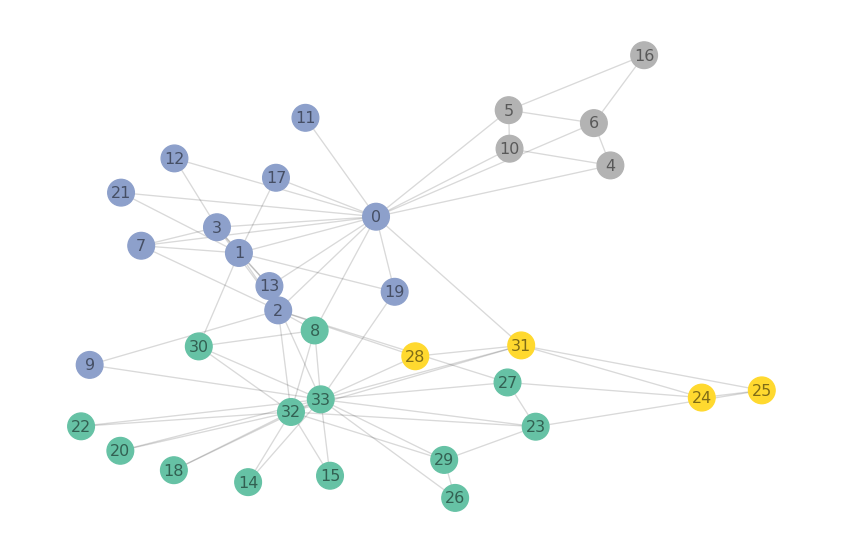

time: 510 ms (started: 2023-05-07 03:28:34 +00:00)


In [5]:
# @title Dataset Handling
dataset = KarateClub()
data = dataset[0]
print(dataset)
print(data)

# Get the indices of the ground truth nodes (train set mask).
train_mask = data.train_mask.cpu().numpy()
train_nodes = np.flatnonzero(train_mask)

# Set one node next to each training node as the validation node to generate the validation 
# set mask and also get its indices.
val_mask = np.zeros((34,), dtype=bool)  # mask of zeros
val_mask[train_nodes + 1] = True        # index into init mask with train node indices, offset by 1 to get validation indices, and set True
val_nodes = np.flatnonzero(val_mask)    # we did not save the validation indices in the last step, so we save them now (same way as train_mask)

# Invert the train + val mask for the unassigned nodes. This generates our test set mask.
# Get its indices as well.
test_mask = ~(train_mask + val_mask)
test_nodes = np.flatnonzero(test_mask)

# Used in some functions in conjunction with pred and true labels to identify misclassified nodes.
full_mask = train_mask + val_mask + test_mask

print("Train Mask Nodes: {}".format(", ".join([str(node) for node in train_nodes])))
print("Val Mask Nodes: {}".format(", ".join([str(node) for node in val_nodes])))
print("Test Mask Nodes: {}".format(", ".join([str(node) for node in test_nodes])))

# Get the true labels.
true_labels = data.y.cpu().numpy()

plt.figure(figsize=(9,6), dpi=96)
ax = plt.gca()
ax.axis("off")

G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx(
    G, pos=pos, ax=ax, with_labels=True, node_size=400, node_color=true_labels, cmap="Set2", 
    font_color=(0,0,0,0.50), edge_color=(0,0,0,0.15)
)

plt.tight_layout()
plt.show()

# Step 4 &ndash; Global Settings
The user has access to some **global settings**:
- Model options such as learning rate, loss criterion, number of epochs, validation set specification, etc.
- TSNE/PCA options such as random state, which algorithm to use, etc.
- Visualizations options such as plot DPI, height, length, and whether to draw the graph's edges and labels.
- Animation options such as which writer to use and the FPS.

**If you want to use the entire graph apart from training nodes for validation, set `validate_on_non_train_nodes` to True.**

There is also the option to toggle whether the node colors are representative of their true class or predicted class (`true_color_nodes`). We don't put it as a global setting because the user may want to set it differently for animation and non-animation visualizations. 
> In non-animations, if `true_color_nodes` is False and `pred_labels` are not provided, the nodes are plotted with a static color. 

One-by-one, the models are trained & evaluated, visualized (best train-time and eval-time embeddings along with loss/acc histories), and the training embedding histories are animated. All the steps are completed for one model before moving to the next. 

In [6]:
# @title Global Settings
# Model
# =============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
num_epochs = 1000
learning_rate = 0.001
criterion = NLLLoss()
save_history=True
return_best_only=True
validate_on_non_train_nodes = True

if validate_on_non_train_nodes:
    # Validate on all graph except training nodes. This makes the validation and test masks equal.
    # It is the least amount of change you need to make to the notebook to validate on all non-train nodes.
    val_mask += test_mask
    test_mask = val_mask

# TSNE/PCA
# =============
# TSNE is non-convex and non-deterministic. This makes its embeddings jump all over the place.
# The resulting animation is very hard to follow. Using the last epoch's 2D embeddings as an
# initial guess for the new ones alleviates this problem a little bit, making the animation
# relatively more stable and easier to follow.

use_tsne = False               # if False, uses PCA
random_state = 42              # both - random seed to use for the backend
if use_tsne:
    use_prev_embed = True      # default = False; uses previous epoch embeddings as init for the current epoch
    perplexity = 10            # default = 30; can't be above number of samples (nodes, in this case)
    early_exaggeration = 16.0  # default = 12.0; makes embeddings appear farther from each other
else:
    whiten = True              # default = False; normalizes the embeddings with singular values and StDev

# Visualization
# =============
fig_max_width_inches = 18
fig_max_height_inches = 6
fig_dpi = 96
draw_edges = False
draw_labels = False

# Animation
# =============
all_hists = []
desired_fps = 30
writer = FFMpegWriter(fps=desired_fps)

time: 8.97 ms (started: 2023-05-07 03:28:35 +00:00)


# Step 5 &ndash; Training and Evaluating Models
The animation blocks tend to take a lot of time. Comment them out if time is not a luxury.

### Training & Evaluation
Training is done on 8 out of 34 nodes, where 4 nodes each are designated the training and validation nodes. We return the best performing model (or latest, not necessarily the best if user specifies), it's corresponding 6D embeddings, predicted labels, and metrics, along with the training history (optional). For animation, the history is necessary. 

Testing is done by evaluating accuracy on all nodes as well as the train-test-val splits. Here, main parameter of interest is the overall accuracy (all 34 nodes) and test accuracy (26 nodes not used in training).

### Visualization
Generates 2D embeddings of the graph nodes for the best trained model and the evaluation model using either TSNE or PCA, and then plots the training history's metrics (requires history to be saved during training) alongside the 2D embeddings. 

Misclassified nodes are marked with a red X. This can be masked to mimic the training (only misclassified train/val nodes marked) or evaluation setting (all misclassified nodes marked).

Embeddings are colored according to node labels. Either the true node label colors or the predicted node label colors can be used by setting or clearing `true_color_nodes`. If say, Node 1 had actual label 'a' (color yellow) and was predicted by the model as 'b' (color red), setting the variable will color the node's embedding as yellow, and clearing it would color it red. **Currently, it is set to True for non-animation visualizations.**

### Embedding History Animation

The drive links to the animations are provided in the first text block.

This step requires the complete training history. **Currently, `true_color_nodes` is set to False for all animations**, and **no misclassified nodes are marked** (`mask_expose_labels` is None).

The animation for the models takes time because first we have to run PCA on all embeddings in addition to video encode, and we can choose to skip them by commenting out those cell blocks. We also provide the option to view the animations side-by-side in the final code block. You can also keep both the model-by-model animations as well as the side-by-side animations, or you may keep just one or none of them, if you choose. 

# A) Graph Convolutional Network (GCN)

In [7]:
# @title Training and Evaluation
#####################
### TRAIN n' EVAL ###
#####################
gcn_model = GCN(dataset).to(device)
optimizer = Adam(gcn_model.parameters(), lr=learning_rate)

# Training - prinouts in function. The returned model object and metrics correspond to the latest or 
# best model. Set or clear the `return_best_only` flag to return the best or latest model.
gcn_model, gcn_model_params, gcn_model_hist = train_model(
    gcn_model, data, train_mask, val_mask, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, 
    modelname="GCN", save_history=save_history, return_best_only=return_best_only
)
gcn_epoch_num = list(gcn_model_params.keys())[0]

# Evaluation - printouts in function. The model's results as evaluated on the full set of nodes and over each
# split separately as well. This returns the overall classification accuracy over the complete set of nodes as
# well as the splitwise accuracy (train and test are the same as returned models, but test accuracy is new). 
print("")
eval_predictions = evaluate_model(gcn_model, data, train_mask, val_mask, test_mask)

print("ACTUAL NODE LABELS:\n\t", ", ".join([str(label) for label in data.y.cpu().numpy()]), sep="")
print("PREDICTED NODE LABELS:\n\t", ", ".join([str(label) for label in eval_predictions["labels"]]), sep="")
print("PREDICTION CONFIDENCE SCORES:\n\t", ", ".join([str(round(conf, 2)) for conf in np.exp(eval_predictions["confidence"])]), sep="")

              [BEST MODEL]              
@ Epoch: 168
Train Acc = 100.00%
Val Acc: 83.33%
Train Loss: 0.49
Val Loss: 0.81
             [LATEST MODEL]             
@ Epoch: 999
Train Acc = 100.00%
Val Acc: 76.67%
Train Loss: 0.11
Val Loss: 0.57
[INFO] Saved and returned best model.

          [EVALUATION RESULTS]          
Overall Acc = 85.29%
Train Acc: 100.00%
Test Acc: 83.33%
ACTUAL NODE LABELS:
	1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0
PREDICTED NODE LABELS:
	1, 1, 0, 1, 3, 3, 3, 1, 0, 0, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0
PREDICTION CONFIDENCE SCORES:
	0.56, 0.49, 0.49, 0.49, 0.55, 0.6, 0.6, 0.44, 0.48, 0.44, 0.55, 0.42, 0.46, 0.37, 0.46, 0.45, 0.61, 0.45, 0.46, 0.35, 0.46, 0.45, 0.46, 0.53, 0.7, 0.69, 0.42, 0.53, 0.4, 0.44, 0.49, 0.53, 0.54, 0.55
time: 8.43 s (started: 2023-05-07 03:28:35 +00:00)


Reducing embeddings to 2D: 100%|##########| 1/1 [00:00<00:00, 80.36it/s]


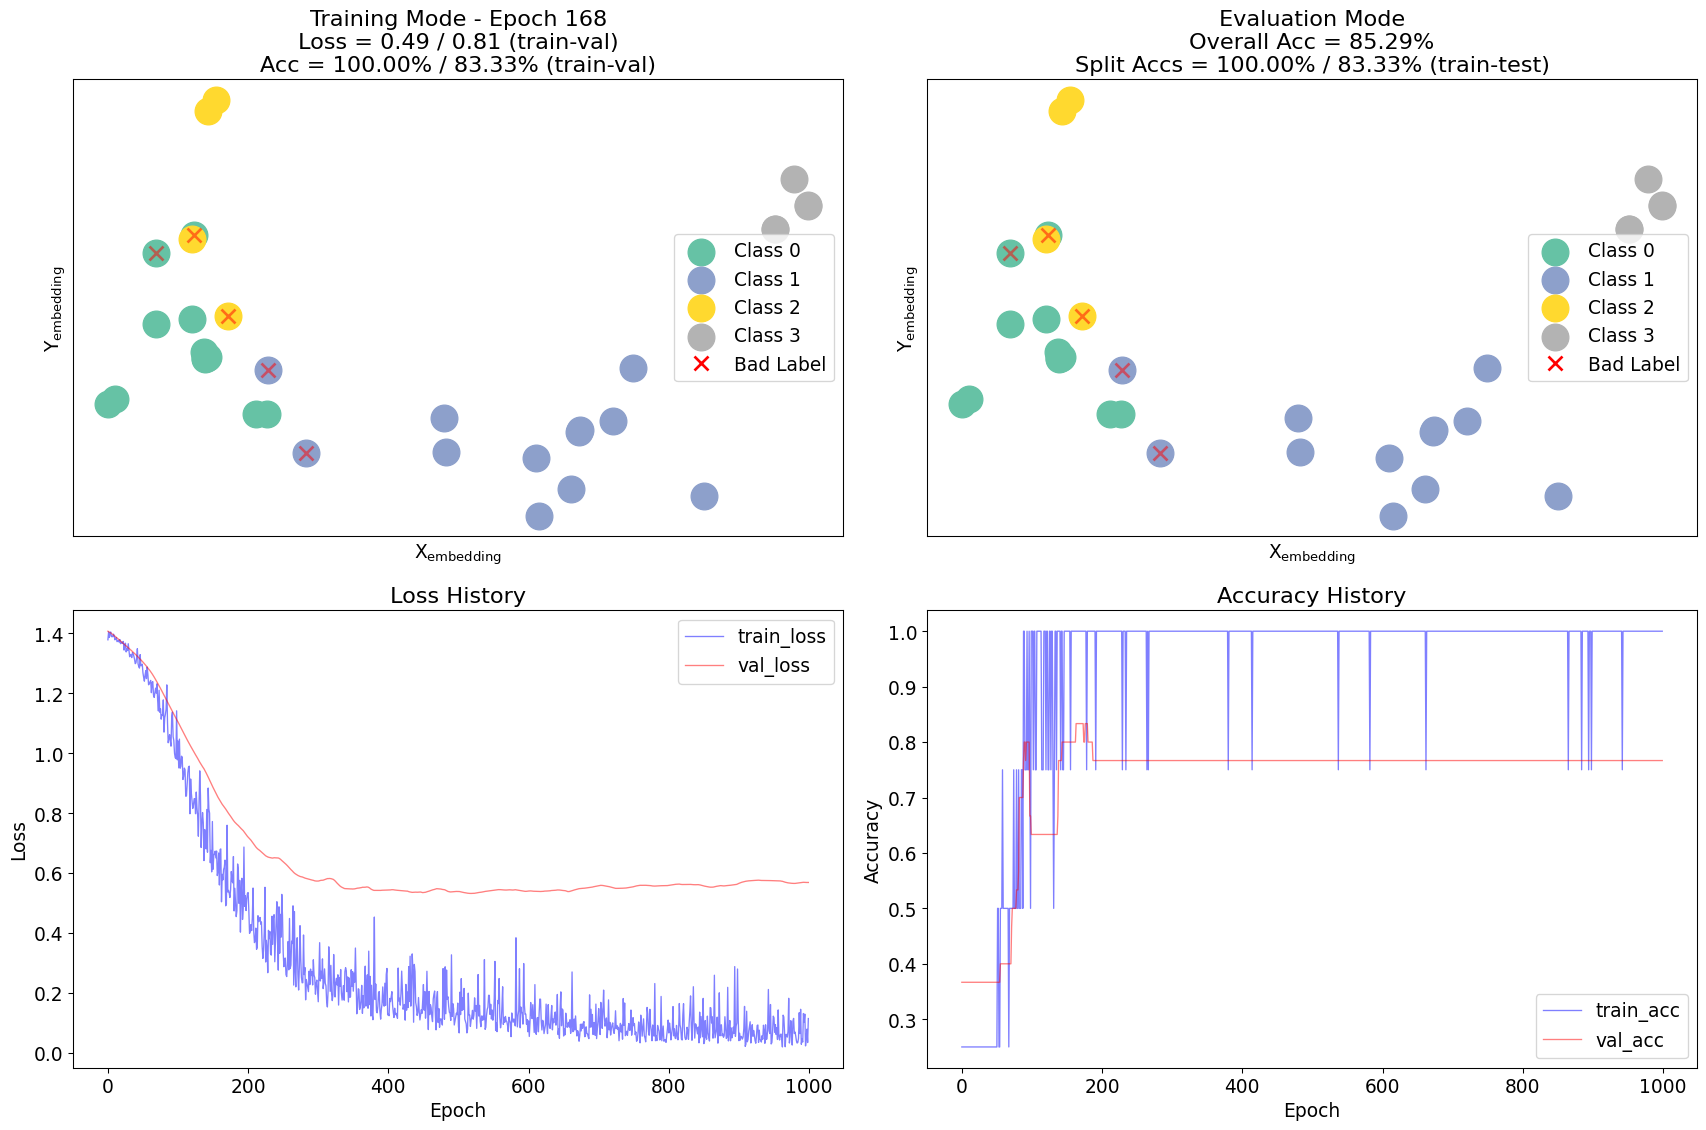

time: 3.21 s (started: 2023-05-07 03:28:43 +00:00)


In [8]:
# @title Visualization
#####################
### VISUALIZATION ###
#####################
# NOTE: The colors of all node markers are according to ground truth by default. Clear `true_color_nodes`
# in the argument to the visualizations to label node markers according to the predicted value. For any 
# non-animation visualization, unless `train_mode` and `eval_mode` are set, the figure does not indicate 
# which nodes are misclassified. In `eval_mode`, all misclassified nodes are indicated with a red X in the
# node marker's middle. In `train_mode`, only the nodes corresponding to the True indices in the boolean
# array in `train_mode_mask` are marked if misclassified. Usually, this will be train_mask + val_mask to
# correctly limit the scope of the training split.

# Note that the validation and training accuracies should be the same in the two embeddings. The embeddings
# themselves will likely not be the same owing to some level of randomness in the dimension reduction.

# Get 2D embeddings.
if use_tsne:
    red_train_embeddings = get_tsne_embeddings(
        [gcn_model_params[gcn_epoch_num]["embeddings"]],
        random_state=random_state,
        early_exaggeration=early_exaggeration,
        perplexity=perplexity,
        use_prev_embed_to_init_new=use_prev_embed
    )
    red_eval_embeddings = get_tsne_embeddings(
        [eval_predictions["embeddings"]],
        random_state=random_state,
        early_exaggeration=early_exaggeration,
        perplexity=perplexity,
        use_prev_embed_to_init_new=use_prev_embed
    )
else:
    red_train_embeddings = get_pca_embeddings([gcn_model_params[gcn_epoch_num]["embeddings"]], whiten=whiten)
    red_eval_embeddings = get_pca_embeddings([eval_predictions["embeddings"]], whiten=whiten)

# Get the trained model's metrics in list format for plotting.
hist_epoch = []
hist_train_loss = []
hist_val_loss = []
hist_train_acc = []
hist_val_acc = []
for epoch, epoch_params in gcn_model_hist.items():
    train_loss, val_loss, train_acc, val_acc = epoch_params["metrics"].values()  # metrics are a subdict {MetricName: value}
    hist_epoch.append(epoch)
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)    
    hist_train_acc.append(train_acc)
    hist_val_acc.append(val_acc)
 
# Initialize figure and axes.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(fig_max_width_inches, 12), dpi=fig_dpi)
ax1, ax2, ax3, ax4 = axes.flatten()

# Update the subplot axes with the visualizations.
ax1 = ax_visualize_2d_embeddings(
    ax1,
    G,
    red_train_embeddings[0],  # the reduced embeddings are returned in list form, even if just one item
    train_epoch=gcn_epoch_num,
    train_metrics=gcn_model_params[gcn_epoch_num]["metrics"],
    true_labels=true_labels, 
    pred_labels=gcn_model_params[gcn_epoch_num]["labels"],
    mask_expose_labels=train_mask + val_mask,
    true_color_nodes=True,
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    cmap="Set2",
)

ax2 = ax_visualize_2d_embeddings(
    ax2,
    G,
    red_eval_embeddings[0],  # the reduced embeddings are returned in list form, even if just one item
    eval_metrics=eval_predictions["metrics"],
    true_labels=true_labels, 
    pred_labels=eval_predictions["labels"],
    mask_expose_labels=full_mask,
    true_color_nodes=True,
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    cmap="Set2"
)

ax3 = ax_visualize_loss_history(ax3, hist_epoch, hist_train_loss, hist_val_loss)
ax4 = ax_visualize_acc_history(ax4, hist_epoch, hist_train_acc, hist_val_acc)

# Tweakers.
plt.tight_layout()
plt.subplots_adjust()
plt.show()

In [9]:
# @title Animation
# #####################
# ##### ANIMATION #####
# #####################
# Takes time as it deals with the entire training history).
if use_tsne:
    red_hist_gcn_embeddings = get_tsne_embeddings(
        [epoch_params["embeddings"] for epoch_params in gcn_model_hist.values()],
        random_state=random_state,
        early_exaggeration=early_exaggeration,
        perplexity=perplexity,
        use_prev_embed_to_init_new=use_prev_embed
    )
else:
    red_hist_gcn_embeddings = get_pca_embeddings(
        [epoch_params["embeddings"] for epoch_params in gcn_model_hist.values()], 
        whiten=whiten)

# Make a copy of the training history and replace the embedding for each epoch with the reduced embeddings.
gcn_model_hist_red_embeddings = deepcopy(gcn_model_hist)
for epoch, epoch_params in gcn_model_hist_red_embeddings.items():
    gcn_model_hist_red_embeddings[epoch]["embeddings"] = red_hist_gcn_embeddings[epoch]

all_hists.append(gcn_model_hist_red_embeddings)

fig = plt.figure(figsize=(9, 6), dpi=fig_dpi)
axes = plt.gca()
anim = animate_embedding_history(
    fig,
    [axes],
    G,
    [gcn_model_hist_red_embeddings],
    true_labels,
    mask_expose_labels=None,
    true_color_nodes=False,
    display_metrics=True,
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    cmap="Set2",
    desired_fps=desired_fps
)
plt.close()  # to prevent shadow figure alongside animation

anim.save("GCN.mp4", dpi=96, writer=writer, progress_callback=animation_progress_callback)
print("\nAnimation saved locally. Converting to HTML for cell output...")
HTML(anim.to_html5_video())

Reducing embeddings to 2D: 100%|##########| 1000/1000 [00:01<00:00, 899.94it/s]


Saving frame: 1000/1000
Animation saved locally. Converting to HTML for cell output...


time: 2min 41s (started: 2023-05-07 03:28:46 +00:00)


# B) Graph Sample and Aggregate (GraphSAGE)


In [10]:
# @title Training and Evaluation
#####################
### TRAIN n' EVAL ###
#####################
gsage_model = GraphSAGE(dataset).to(device)
optimizer = Adam(gsage_model.parameters(), lr=learning_rate)

gsage_model, gsage_model_params, gsage_model_hist = train_model(
    gsage_model, data, train_mask, val_mask, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, 
    modelname="GSAGE", save_history=save_history, return_best_only=return_best_only
)
gsage_epoch_num = list(gsage_model_params.keys())[0]

print("")
eval_predictions = evaluate_model(gsage_model, data, train_mask, val_mask, test_mask)

print("ACTUAL NODE LABELS:\n\t", ", ".join([str(label) for label in data.y.cpu().numpy()]), sep="")
print("PREDICTED NODE LABELS:\n\t", ", ".join([str(label) for label in eval_predictions["labels"]]), sep="")
print("PREDICTION CONFIDENCE SCORES:\n\t", ", ".join([str(round(conf, 2)) for conf in np.exp(eval_predictions["confidence"])]), sep="")

              [BEST MODEL]              
@ Epoch: 65
Train Acc = 100.00%
Val Acc: 80.00%
Train Loss: 1.03
Val Loss: 1.23
             [LATEST MODEL]             
@ Epoch: 999
Train Acc = 100.00%
Val Acc: 56.67%
Train Loss: 0.02
Val Loss: 1.54
[INFO] Saved and returned best model.

          [EVALUATION RESULTS]          
Overall Acc = 82.35%
Train Acc: 100.00%
Test Acc: 80.00%
ACTUAL NODE LABELS:
	1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0
PREDICTED NODE LABELS:
	1, 1, 1, 1, 3, 3, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0
PREDICTION CONFIDENCE SCORES:
	0.32, 0.32, 0.28, 0.31, 0.35, 0.32, 0.29, 0.31, 0.33, 0.3, 0.29, 0.3, 0.31, 0.31, 0.3, 0.3, 0.3, 0.31, 0.3, 0.31, 0.31, 0.32, 0.31, 0.29, 0.44, 0.35, 0.29, 0.28, 0.28, 0.27, 0.3, 0.3, 0.27, 0.28
time: 4.76 s (started: 2023-05-07 03:31:28 +00:00)


Reducing embeddings to 2D: 100%|##########| 1/1 [00:00<00:00, 666.08it/s]


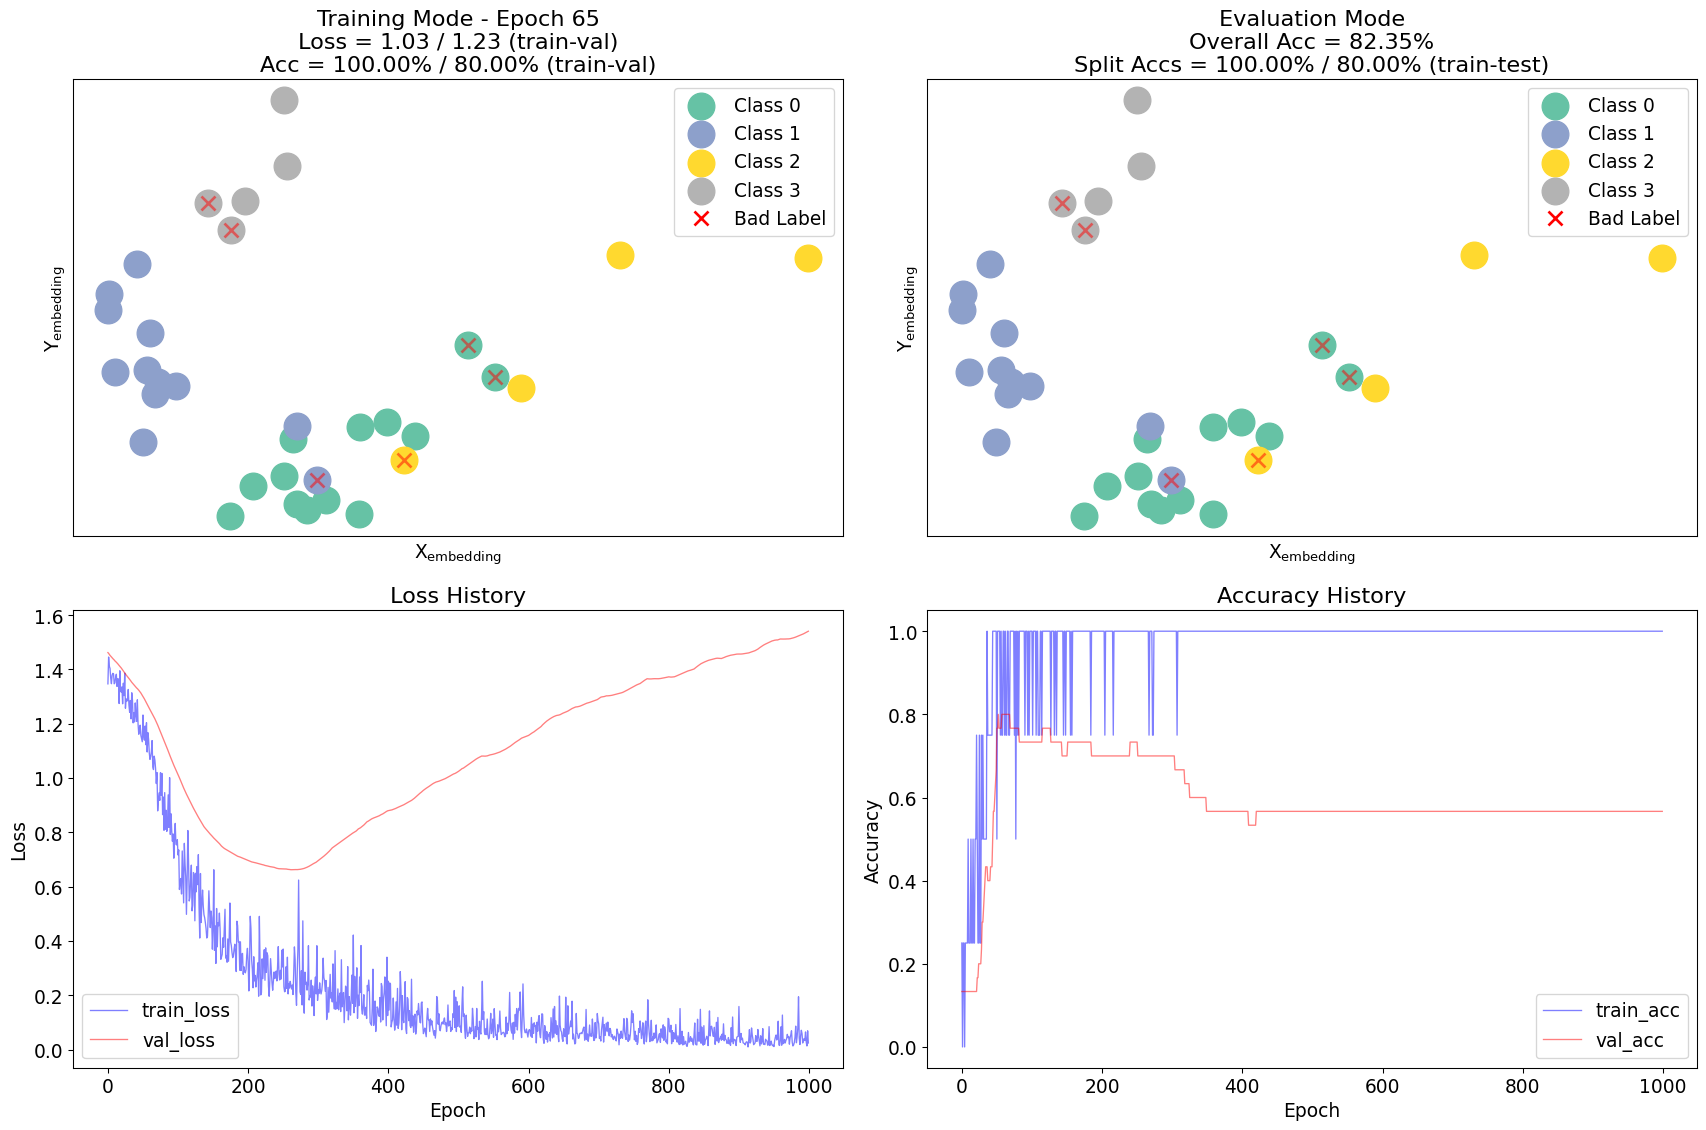

time: 1.63 s (started: 2023-05-07 03:31:33 +00:00)


In [11]:
# @title Visualization
#####################
### VISUALIZATION ###
#####################
if use_tsne:
    red_train_embeddings = get_tsne_embeddings(
        [gsage_model_params[gsage_epoch_num]["embeddings"]],
        random_state=random_state,
        early_exaggeration=early_exaggeration,
        perplexity=perplexity,
        use_prev_embed_to_init_new=use_prev_embed
    )
    red_eval_embeddings = get_tsne_embeddings(
        [eval_predictions["embeddings"]],
        random_state=random_state,
        early_exaggeration=early_exaggeration,
        perplexity=perplexity,
        use_prev_embed_to_init_new=use_prev_embed
    )
else:
    red_train_embeddings = get_pca_embeddings([gsage_model_params[gsage_epoch_num]["embeddings"]], whiten=whiten)
    red_eval_embeddings = get_pca_embeddings([eval_predictions["embeddings"]], whiten=whiten)

hist_epoch = []
hist_train_loss = []
hist_val_loss = []
hist_train_acc = []
hist_val_acc = []
for epoch, epoch_params in gsage_model_hist.items():
    train_loss, val_loss, train_acc, val_acc = epoch_params["metrics"].values()  # metrics are a subdict {MetricName: value}
    hist_epoch.append(epoch)
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)    
    hist_train_acc.append(train_acc)
    hist_val_acc.append(val_acc)
 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(fig_max_width_inches, 12), dpi=fig_dpi)
ax1, ax2, ax3, ax4 = axes.flatten()

ax1 = ax_visualize_2d_embeddings(
    ax1,
    G,
    red_train_embeddings[0],  # the reduced embeddings are returned in list form, even if just one item
    train_epoch=gsage_epoch_num,
    train_metrics=gsage_model_params[gsage_epoch_num]["metrics"],
    true_labels=true_labels, 
    pred_labels=gsage_model_params[gsage_epoch_num]["labels"],
    mask_expose_labels=train_mask + val_mask,
    true_color_nodes=True,
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    cmap="Set2",
)

ax2 = ax_visualize_2d_embeddings(
    ax2,
    G,
    red_eval_embeddings[0],  # the reduced embeddings are returned in list form, even if just one item
    eval_metrics=eval_predictions["metrics"],
    true_labels=true_labels, 
    pred_labels=eval_predictions["labels"],
    mask_expose_labels=full_mask,
    true_color_nodes=True,
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    cmap="Set2",
)

ax3 = ax_visualize_loss_history(ax3, hist_epoch, hist_train_loss, hist_val_loss)
ax4 = ax_visualize_acc_history(ax4, hist_epoch, hist_train_acc, hist_val_acc)

# Tweakers.
plt.tight_layout()
plt.subplots_adjust()
plt.show()

In [12]:
# @title Animation
# #####################
# ##### ANIMATION #####
# #####################
if use_tsne:
    red_hist_gsage_embeddings = get_tsne_embeddings(
        [epoch_params["embeddings"] for epoch_params in gsage_model_hist.values()],
        random_state=random_state,
        early_exaggeration=early_exaggeration,
        perplexity=perplexity,
        use_prev_embed_to_init_new=use_prev_embed
    )
else:
    red_hist_gsage_embeddings = get_pca_embeddings(
        [epoch_params["embeddings"] for epoch_params in gsage_model_hist.values()], 
        whiten=whiten)

gsage_model_hist_red_embeddings = deepcopy(gsage_model_hist)
for epoch, epoch_params in gsage_model_hist_red_embeddings.items():
    gsage_model_hist_red_embeddings[epoch]["embeddings"] = red_hist_gsage_embeddings[epoch]

all_hists.append(gsage_model_hist_red_embeddings)

fig = plt.figure(figsize=(9, 6), dpi=fig_dpi)
axes = plt.gca()
anim = animate_embedding_history(
    fig,
    [axes],
    G,
    [gsage_model_hist_red_embeddings],
    true_labels,
    mask_expose_labels=None,
    true_color_nodes=False,
    display_metrics=True,
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    cmap="Set2",
    desired_fps=desired_fps
)
plt.close()  # to prevent shadow figure alongside animation

anim.save("GSAGE.mp4", dpi=96, writer=writer, progress_callback=animation_progress_callback)
print("\nAnimation saved locally. Converting to HTML for cell output...")
HTML(anim.to_html5_video())

Reducing embeddings to 2D: 100%|##########| 1000/1000 [00:00<00:00, 1441.80it/s]


Saving frame: 1000/1000
Animation saved locally. Converting to HTML for cell output...


time: 2min 26s (started: 2023-05-07 03:31:34 +00:00)


# C) Graph Attention Network (GAT)



In [13]:
# @title Training and Evaluation
#####################
### TRAIN n' EVAL ###
#####################
gat_model = GAT(dataset).to(device)
optimizer = Adam(gat_model.parameters(), lr=learning_rate)

gat_model, gat_model_params, gat_model_hist = train_model(
    gat_model, data, train_mask, val_mask, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, 
    modelname="GAT", save_history=save_history, return_best_only=return_best_only
)
gat_epoch_num = list(gat_model_params.keys())[0]

print("")
eval_predictions = evaluate_model(gat_model, data, train_mask, val_mask, test_mask)

print("ACTUAL NODE LABELS:\n\t", ", ".join([str(label) for label in data.y.cpu().numpy()]), sep="")
print("PREDICTED NODE LABELS:\n\t", ", ".join([str(label) for label in eval_predictions["labels"]]), sep="")
print("PREDICTION CONFIDENCE SCORES:\n\t", ", ".join([str(round(conf, 2)) for conf in np.exp(eval_predictions["confidence"])]), sep="")

              [BEST MODEL]              
@ Epoch: 427
Train Acc = 100.00%
Val Acc: 86.67%
Train Loss: 0.12
Val Loss: 0.61
             [LATEST MODEL]             
@ Epoch: 999
Train Acc = 100.00%
Val Acc: 83.33%
Train Loss: 0.03
Val Loss: 0.70
[INFO] Saved and returned best model.

          [EVALUATION RESULTS]          
Overall Acc = 88.24%
Train Acc: 100.00%
Test Acc: 86.67%
ACTUAL NODE LABELS:
	1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0
PREDICTED NODE LABELS:
	1, 1, 1, 1, 3, 3, 3, 1, 0, 0, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0
PREDICTION CONFIDENCE SCORES:
	0.77, 0.75, 0.43, 0.77, 0.9, 0.9, 0.9, 0.77, 0.85, 0.85, 0.9, 0.64, 0.77, 0.62, 0.87, 0.87, 0.91, 0.78, 0.87, 0.52, 0.87, 0.78, 0.87, 0.94, 0.94, 0.94, 0.86, 0.94, 0.52, 0.83, 0.84, 0.94, 0.84, 0.53
time: 9.96 s (started: 2023-05-07 03:34:00 +00:00)


Reducing embeddings to 2D: 100%|##########| 1/1 [00:00<00:00, 640.16it/s]


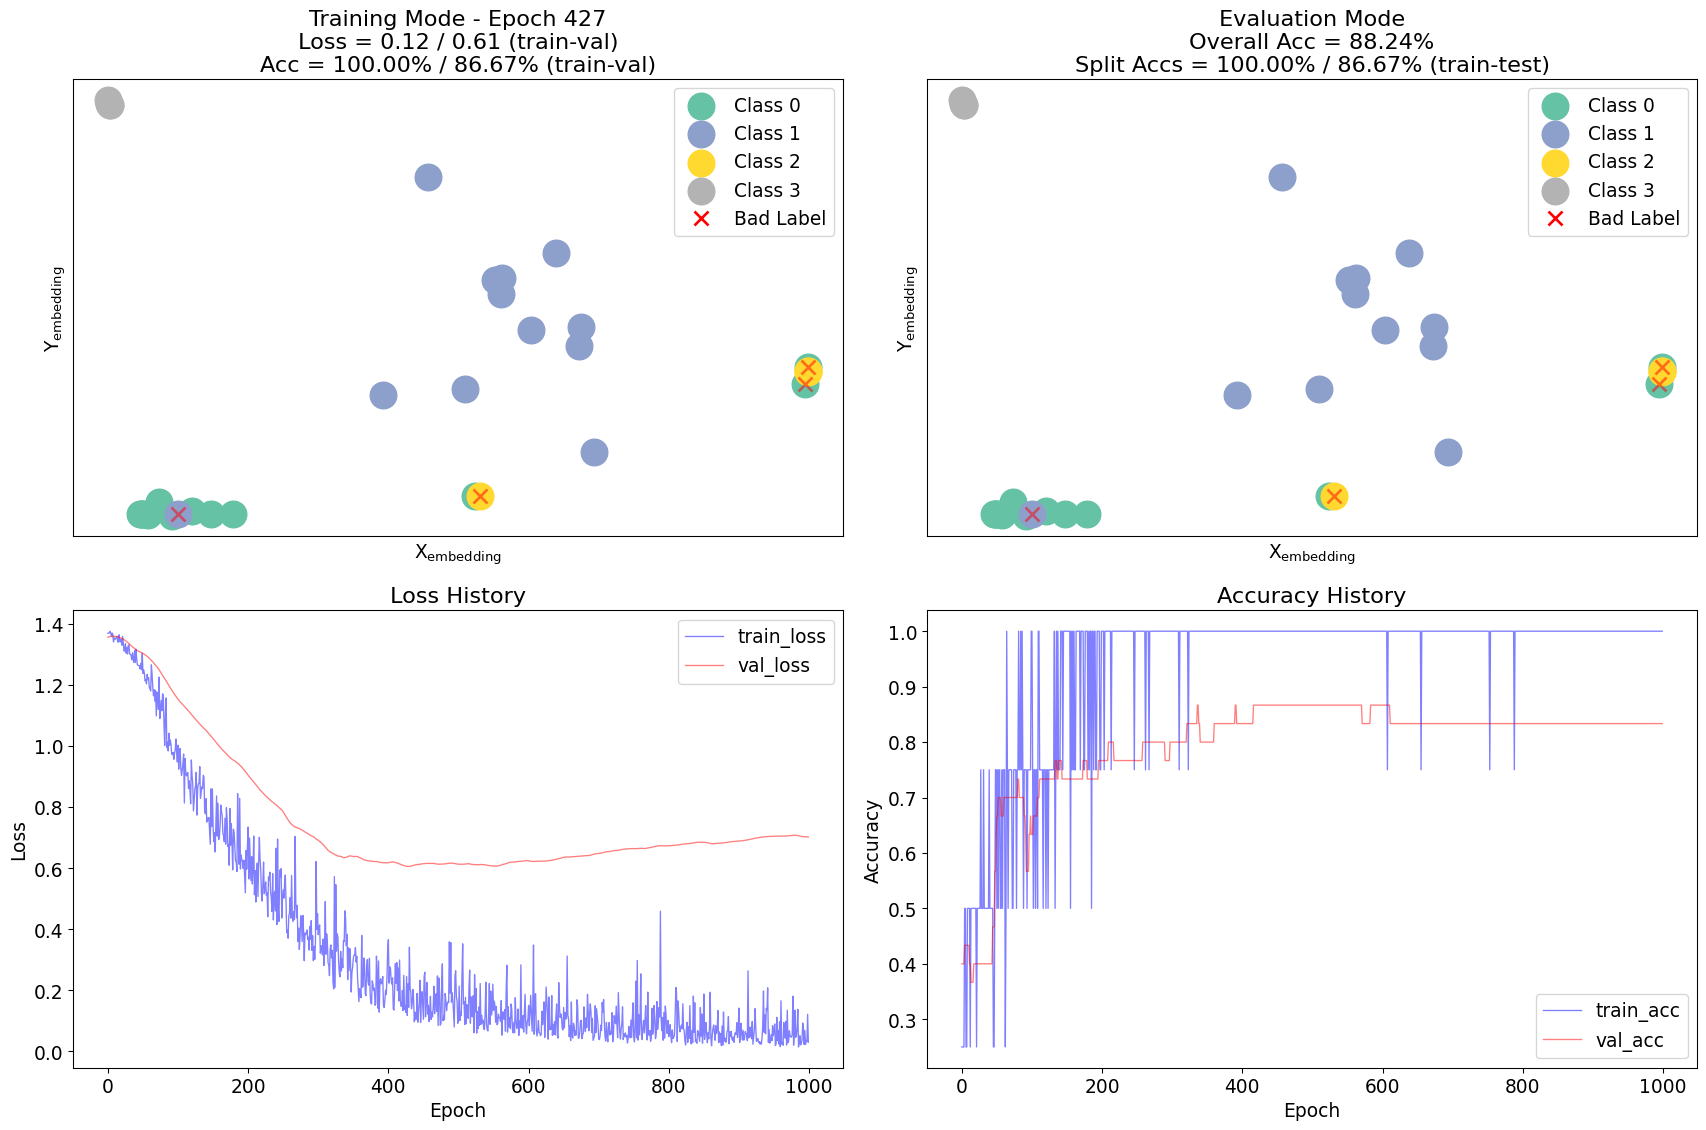

time: 1.35 s (started: 2023-05-07 03:34:10 +00:00)


In [14]:
# @title Visualization
#####################
### VISUALIZATION ###
#####################
if use_tsne:
    red_train_embeddings = get_tsne_embeddings(
        [gat_model_params[gat_epoch_num]["embeddings"]],
        random_state=random_state,
        early_exaggeration=early_exaggeration,
        perplexity=perplexity,
        use_prev_embed_to_init_new=use_prev_embed
    )
    red_eval_embeddings = get_tsne_embeddings(
        [eval_predictions["embeddings"]],
        random_state=random_state,
        early_exaggeration=early_exaggeration,
        perplexity=perplexity,
        use_prev_embed_to_init_new=use_prev_embed
    )
else:
    red_train_embeddings = get_pca_embeddings([gat_model_params[gat_epoch_num]["embeddings"]], whiten=whiten)
    red_eval_embeddings = get_pca_embeddings([eval_predictions["embeddings"]], whiten=whiten)

# Get the trained model's metrics in list format for plotting.
hist_epoch = []
hist_train_loss = []
hist_val_loss = []
hist_train_acc = []
hist_val_acc = []
for epoch, epoch_params in gat_model_hist.items():
    train_loss, val_loss, train_acc, val_acc = epoch_params["metrics"].values()  # metrics are a subdict {MetricName: value}
    hist_epoch.append(epoch)
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)    
    hist_train_acc.append(train_acc)
    hist_val_acc.append(val_acc)
 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(fig_max_width_inches, 12), dpi=fig_dpi)
ax1, ax2, ax3, ax4 = axes.flatten()

ax1 = ax_visualize_2d_embeddings(
    ax1,
    G,
    red_train_embeddings[0],  # the reduced embeddings are returned in list form, even if just one item
    train_epoch=gat_epoch_num,
    train_metrics=gat_model_params[gat_epoch_num]["metrics"],
    true_labels=true_labels, 
    pred_labels=gat_model_params[gat_epoch_num]["labels"],
    mask_expose_labels=train_mask + val_mask,
    true_color_nodes=True,
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    cmap="Set2",
)

ax2 = ax_visualize_2d_embeddings(
    ax2,
    G,
    red_eval_embeddings[0],  # the reduced embeddings are returned in list form, even if just one item
    eval_metrics=eval_predictions["metrics"],
    true_labels=true_labels, 
    pred_labels=eval_predictions["labels"],
    mask_expose_labels=full_mask,
    true_color_nodes=True,
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    cmap="Set2",
)

ax3 = ax_visualize_loss_history(ax3, hist_epoch, hist_train_loss, hist_val_loss)
ax4 = ax_visualize_acc_history(ax4, hist_epoch, hist_train_acc, hist_val_acc)

# Tweakers.
plt.tight_layout()
plt.subplots_adjust()
plt.show()

In [15]:
# @title Animation
# #####################
# ##### ANIMATION #####
# #####################
if use_tsne:
    red_hist_gat_embeddings = get_tsne_embeddings(
        [epoch_params["embeddings"] for epoch_params in gat_model_hist.values()],
        random_state=random_state,
        early_exaggeration=early_exaggeration,
        perplexity=perplexity,
        use_prev_embed_to_init_new=use_prev_embed
    )
else:
    red_hist_gat_embeddings = get_pca_embeddings(
        [epoch_params["embeddings"] for epoch_params in gat_model_hist.values()], 
        whiten=whiten)

gat_model_hist_red_embeddings = deepcopy(gat_model_hist)
for epoch, epoch_params in gat_model_hist_red_embeddings.items():
    gat_model_hist_red_embeddings[epoch]["embeddings"] = red_hist_gat_embeddings[epoch]

all_hists.append(gat_model_hist_red_embeddings)

fig = plt.figure(figsize=(9, 6), dpi=fig_dpi)
axes = plt.gca()
anim = animate_embedding_history(
    fig,
    [axes],
    G,
    [gat_model_hist_red_embeddings],
    true_labels,
    mask_expose_labels=None,
    true_color_nodes=False,
    display_metrics=True,
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    cmap="Set2",
    desired_fps=desired_fps
)
plt.close()  # to prevent shadow figure alongside animation

anim.save("GAT.mp4", dpi=96, writer=writer, progress_callback=animation_progress_callback)
print("\nAnimation saved locally. Converting to HTML for cell output...")
HTML(anim.to_html5_video())

Reducing embeddings to 2D: 100%|##########| 1000/1000 [00:00<00:00, 1819.39it/s]


Saving frame: 1000/1000
Animation saved locally. Converting to HTML for cell output...


time: 2min 29s (started: 2023-05-07 03:34:12 +00:00)


# Side-by-side Animation of Embedding Histories
For best view, collapse everything other than the editor.

In [16]:
# @title SBS Animations
#####################
# SIDE BY SIDE ANIM #
#####################
if not all_hists:
    if use_tsne:
        red_hist_gcn_embeddings = get_tsne_embeddings(
            [epoch_params["embeddings"] for epoch_params in gcn_model_hist.values()],
            random_state=random_state,
            early_exaggeration=early_exaggeration,
            perplexity=perplexity,
            use_prev_embed_to_init_new=use_prev_embed
        )
        red_hist_gsage_embeddings = get_tsne_embeddings(
            [epoch_params["embeddings"] for epoch_params in gsage_model_hist.values()],
            random_state=random_state,
            early_exaggeration=early_exaggeration,
            perplexity=perplexity,
            use_prev_embed_to_init_new=use_prev_embed
        )
        red_hist_gat_embeddings = get_tsne_embeddings(
            [epoch_params["embeddings"] for epoch_params in gat_model_hist.values()],
            random_state=random_state,
            early_exaggeration=early_exaggeration,
            perplexity=perplexity,
            use_prev_embed_to_init_new=use_prev_embed
        )
    else:
        red_hist_gcn_embeddings = get_pca_embeddings(
            [epoch_params["embeddings"] for epoch_params in gcn_model_hist.values()], 
            whiten=whiten
        )
        red_hist_gsage_embeddings = get_pca_embeddings(
            [epoch_params["embeddings"] for epoch_params in gsage_model_hist.values()], 
            whiten=whiten
        )
        red_hist_gat_embeddings = get_pca_embeddings(
            [epoch_params["embeddings"] for epoch_params in gat_model_hist.values()], 
            whiten=whiten
        )

    gcn_model_hist_red_embeddings = deepcopy(gcn_model_hist)
    for epoch, epoch_params in gcn_model_hist_red_embeddings.items():
        gcn_model_hist_red_embeddings[epoch]["embeddings"] = red_hist_gcn_embeddings[epoch]
    gsage_model_hist_red_embeddings = deepcopy(gsage_model_hist)
    for epoch, epoch_params in gsage_model_hist_red_embeddings.items():
        gsage_model_hist_red_embeddings[epoch]["embeddings"] = red_hist_gsage_embeddings[epoch]
    gat_model_hist_red_embeddings = deepcopy(gat_model_hist)
    for epoch, epoch_params in gat_model_hist_red_embeddings.items():
        gat_model_hist_red_embeddings[epoch]["embeddings"] = red_hist_gat_embeddings[epoch]

    all_hists = [gcn_model_hist_red_embeddings, gsage_model_hist_red_embeddings, gat_model_hist_red_embeddings]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(fig_max_width_inches, fig_max_height_inches), dpi=fig_dpi)
anim = animate_embedding_history(
    fig,
    axes,
    G,
    all_hists,
    true_labels,
    mask_expose_labels=None,
    true_color_nodes=False,
    display_metrics=True,
    cmap="Set2",
    draw_edges=draw_edges,
    draw_labels=draw_labels,
    desired_fps=desired_fps
)
plt.tight_layout()
plt.subplots_adjust()
plt.close()

anim.save("all_models_together.mp4", dpi=96, writer=writer, progress_callback=animation_progress_callback)
print("\nAnimation saved locally. Converting to HTML for cell output...")
print("History 1 = GCN, History 2 = GraphSAGE, History 3 = GAT")
HTML(anim.to_html5_video())

Saving frame: 1000/1000
Animation saved locally. Converting to HTML for cell output...
History 1 = GCN, History 2 = GraphSAGE, History 3 = GAT


time: 5min 44s (started: 2023-05-07 03:36:41 +00:00)


# IGNORE

In [17]:
# video_files = ['GCN.mp4', 'GSAGE.mp4', 'GAT.mp4']
# num_videos = len(video_files)

# # Init capture objects on each video file.
# videos = [cv2.VideoCapture(video_file) for video_file in video_files]

# # Get video properties
# num_frames = [int(video.get(cv2.CAP_PROP_FRAME_COUNT)) for video in videos]
# framerate = min([int(video.get(cv2.CAP_PROP_FPS)) for video in videos])

# # Longest frame duration on minimum framerate
# longest_frame_duration = 1000 / framerate  

# # Shape for black images when video ends
# width = int(videos[0].get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(videos[0].get(cv2.CAP_PROP_FRAME_HEIGHT))
# shape = (height, width)

# # Set up the figure and subplots
# fig, axes = plt.subplots(1, num_videos, figsize=(6*num_videos, 4), dpi=96)

# # Animate callback
# def update(frame, videos, axes, num_frames, shape):
#     for i, (video, ax) in enumerate(zip(videos, axes)):
#         # Loop video if ended
#         video.set(cv2.CAP_PROP_POS_FRAMES, frame % num_frames[i]) 
#         # Clear axis from previous iteration
#         ax.cla()
#         # Remove the axis guides
#         ax.axis("off")
        
#         # Read in the frame
#         ret, img = video.read()
#         if ret:
#             # Convert image to RGB and display on axis
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             ax.imshow(img)
#         else:
#             # If the read fails
#             black = np.zeros(shape, dtype=np.uint8)
#             ax.imshow(black)
    
#     # Tighten between and around subplot
#     fig.tight_layout()
#     fig.subplots_adjust(wspace=0.1)

# plt.close()

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=max(num_frames), 
#     fargs=(videos, axes, num_frames, shape,), 
#     interval=longest_frame_duration, 
#     blit=False, 
#     repeat=True)

# anim.save("all_models.mp4", dpi=96, writer=writer, progress_callback=animation_progress_callback)

# # Free up OpenCV.
# for video in videos:
#     video.release()

# # I don't know how it works but it does. Can't use anim.to_html_5 because we need to free up OpenCV.
# # If we free up OpenCV before displaying as html 5, the video doesn't render. If we free up OpenCV
# # after outputting to HTML 5, the output cell does not update for some reason. 

# # Current Solution: https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab
# # Another solution is to release captures in the next cell block, but that would be somewhat cumbersome.
# mp4 = open('all_models.mp4','rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video controls loop>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)

time: 442 µs (started: 2023-05-07 03:42:25 +00:00)


In [18]:
# Free up OpenCV.
# for video in videos:
#     video.release()

time: 318 µs (started: 2023-05-07 03:42:25 +00:00)


In [19]:
# FOR GIFS. Sadly, can't view them locally at any given point since they are gifs.
# But, good for short loops.
# =================================================================================
# from PIL import Image, ImageSequence
# plt.rcParams.update({'font.size': 14})

# video_files = ['GCN.gif', 'GSAGE.gif', 'GAT.gif']
# num_videos = len(video_files)

# # Load the videos using PIL
# videos = [Image.open(video_file) for video_file in video_files]

# # Get the number of frames and the duration of each frame
# num_frames = [video.n_frames for video in videos]
# frame_durations = [video.info['duration'] for video in videos]

# # Set up the Matplotlib figure and subplots
# fig, axes = plt.subplots(1, num_videos, figsize=(6*num_videos, 4), dpi=96)

# # Animate
# def update(frame, videos, axes, num_frames):
#     for i, (video, ax) in enumerate(zip(videos, axes)):
#         ax.cla()
#         ax.axis("off")
#         video.seek(frame % num_frames[i])  # Loop the video when it reaches the end
#         ax.imshow(video.convert('RGBA'))
#     fig.tight_layout()
#     fig.subplots_adjust(wspace=0.1)

# plt.close()
# anim = FuncAnimation(fig, update, frames=max(num_frames), fargs=(videos, axes, num_frames), interval=max(frame_durations), blit=False, repeat=True)
# anim.save("all_models.gif", dpi=96, writer=writer, progress_callback=animation_progress_callback)
# HTML(anim.to_html5_video())

time: 350 µs (started: 2023-05-07 03:42:25 +00:00)
